In [1]:
import pandas as pd
import numpy as np
import json
import os
from pathlib import Path
from collections import defaultdict
#from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
#from scipy import stats
#from sklearn.metrics import r2_score
#from scipy.optimize import curve_fit
#from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')



# ============================================
# CONFIGURATION
# ============================================
# Set plotting style
SAVE_DIR = "Comparison_outputs"
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
sns.set_context("talk", font_scale=0.9)
sns.set_style("whitegrid")
CONFIG = {
    # Literature analysis files
    'literature_csv': 'Saved_files_new/enhanced_method_analysis_2024-12-15.csv',
    'topic_names_json': 'Saved_files_new/topic_names_2024-12-15.json',
    'topic_ngrams_json': 'Saved_files_new/topic_specific_tfidf_ngrams_2024-12-15.json',  # Optional
    'term_frequencies_json': 'Saved_files_new/term_frequencies_2024-12-15.json',  # Optional
    'survey_csv': 'C:\git_repos\Questionair-analysis\Data\method_comparison_results.csv',
     'literature_separator': ',',  
    # Software mapping files
    'software_csv': 'software_analysis_output/software_methods_with_mis_updated.csv',
    'ggt_results_csv': 'Saved_files_new/ggt_results_dual.csv',  # Optional
    'software_separator': ';', 
    
    # CSV parsing settings
    'csv_separator': ';',
    'decimal_separator': ',',
    
    # Software data settings
    'mis_row_label': 'Gjennomsnittlig score (MIS)',
    'raw_mis_row_label': 'Sum raw implementation score',
    'non_method_prefixes': ('Include?', 'Vendor', 'Type', 'Coverage','Type of modelling', 'OSMM Score', 'OSMM - product maturity', 'OSMM - product maturity - API (+1)',
                            'OSMM - product maturity - Implementeringseksempel(+1)', 'OSMM - product maturity - Get started (+2)','OSMM - product maturity - Community(+1)', 
                            'OSMM - product maturity - REST, GraphQL, MQTT, Postman etc(+1)','OSMM - product maturity - Dataformater(JSON, CSV, XML)(+1)', 
                            'OSMM - product maturity - CIM kompatibel (+2)', 'OSMM - product maturity - Integrasjonsmuligheter (+1)', 'OSMM - industry adoption', 
                            'OSMM - industry adoption-Normalized litterature-count', 'OSMM - industry adoption-litterature-count', 'OSMM - industry adoption Normalized-Survey-count', 
                            'OSMM - industry adoption-Survey-count', 'Numerical-solvers'
                            )
}


### Method Category handeling

In [3]:
# category configuration
SOFTWARE_NAMES = [
'Power Factory','Digisilent','DINIS','ERACS','ETAP Distribution Network Analysis','ETAP','IPSA','Power World',
'PSS/E','PSSE/SINCAL','SKM Power Tools','OpenDSS','Matlab & Simulink','DYMOLA',
'MathPower','RelyPES','GridLAB-D','PyPSA','TARA','Promaps',
'PyPower','GridCal Sk','PandaPower','MatDyn','NEPLAN','PSAT','CYMEDIST','Excel',
'Synergi Electric','Dynawo','OpenModellica','Sienna','PowerModels.jl','PowerSystems.jl & PowerSimulations.jl',' PowerFlows.jl',
'Joulia','POWSYBL','Hitachi Network Manager','ABB Network Manager','ABB Miniscada','Spectrum Power','Siemens Spectrum','CIMPLICITY Scada','eTerra','Netbas','Powel','Volue','Trimble NIS','Trimble','GAMS'
]

METHOD_CATEGORY = {
    # Power system optimization

    "optimal power flow": "Power system optimization",
    "security-constrained optimal power flow": "Power system optimization",
    "security constrained unit commitment": "Power system optimization",
    "non linear optimal power flow": "Power system optimization",
    "multi-period optimisation": "Power system optimization",
    "unit commitment": "Power system optimization",
    "economic dispatch ed": "Power system optimization",
    "economic dispatch": "Power system optimization",
    "optimal capacity configuration": "Power system optimization",

    #Reliability and contingency analysis
    "contingency analysis": "Reliability and contingency analysis",
    "line outage distribution factor": "Reliability and contingency analysis",
    "power transfer distribution factor": "Reliability and contingency analysis",
    "system average interruption duration index": "Reliability and contingency analysis",
    "system average interruption frequency index": "Reliability and contingency analysis",
    "minimal cut set": "Reliability and contingency analysis",
    "energy resilience analysis": "Reliability and contingency analysis",
    "power system restoration": "Reliability and contingency analysis",
    "expected energy not served": "Reliability and contingency analysis",
    "loss of load expectancy": "Reliability and contingency analysis",

    # Power, load and capacity modeling 
    "power flow analysis": "Power, load and capacity modeling",
    "dynamic line rating": "Power, load and capacity modeling",
    "demand response": "Power, load and capacity modeling",
    "load balancing": "Power, load and capacity modeling",
    "power system flexibility": "Power, load and capacity modeling",
    "load shedding analysis": "Power, load and capacity modeling",
    "hosting capacity": "Power, load and capacity modeling",
    "energy consumption modeling": "Power, load and capacity modeling",
    "power generation modeling": "Power, load and capacity modeling",
    "dynamic resource allocation": "Power, load and capacity modeling",
    "modal analysis": "Power, load and capacity modeling",
    "energy demand forecasting": "Power, load and capacity modeling",
    "levelized cost of energy lcoe": "Power, load and capacity modeling",
    "load forecasting": "Power, load and capacity modeling",
    "short-term load forecasting": "Power, load and capacity modeling",
    "power forecasting": "Power, load and capacity modeling",
    "wind power prediction": "Power, load and capacity modeling",

    
    # Voltage and frequency analysis
    "power quality assessment": "Voltage and frequency analysis",
    "power quality disturbance": "Voltage and frequency analysis",
    "phase-locked loop": "Voltage and frequency analysis",
    "frequency nadir": "Voltage and frequency analysis",
    "voltage stability": "Voltage and frequency analysis",
    "load frequency control": "Voltage and frequency analysis",
    "power factor correction": "Voltage and frequency analysis",
    "voltage control strategy": "Voltage and frequency analysis",
    "dynamic voltage restorer": "Voltage and frequency analysis",
    "dynamic reactive power compensation": "Voltage and frequency analysis",
    "power system stabilizer": "Voltage and frequency analysis",
    "static var compensator": "Voltage and frequency analysis",
    "shunt active power filter": "Voltage and frequency analysis",
    "partial discharge pd": "Voltage and frequency analysis",
    "power quality disturbance": "Voltage and frequency analysis",
    "doubly-fed induction": "Voltage and frequency analysis",
    "reactive power sharing": "Voltage and frequency analysis",
    "frequency variation": "Voltage and frequency analysis",
    
    # Probabilistic methods
    "monte-carlo": "Probabilistic methods",
    "sequential monte carlo": "Probabilistic methods",
    "markov chain monte carlo": "Probabilistic methods",
    "probabilistic analysis": "Probabilistic methods",
    "probabilistic-forecasting": "Probabilistic methods",
    "two-stage stochastic": "Probabilistic methods",
    "stochastic unit commitment": "Probabilistic methods",
    "stochastic programming": "Probabilistic methods",
    "stochastic model": "Probabilistic methods",
    "stochastic simulation": "Probabilistic methods",
    "point estimate method": "Probabilistic methods",
    "bayesian optimization": "Optimization",

    # Optimization (mathematical + metaheuristics)
    "linear programming": "Optimization",
    "mixed integer linear programming": "Optimization",
    "quadratic programming": "Optimization",
    "second-order cone": "Optimization",
    "interior point method": "Optimization",
    "dynamic programming": "Optimization",
    "model predictive control": "Optimization",
    "multi-objective optimization": "Optimization",
    "heuristic optimization": "Optimization",
    "metaheuristics": "Optimization",
    "genetic algorithm": "Optimization",
    "particle swarm optimization": "Optimization",
    "binary particle swarm": "Optimization",
    "multi-objective particle swarm optimization": "Optimization",
    "ant colony optimization": "Optimization",
    "artificial bee colony": "Optimization",
    "cuckoo search": "Optimization",
    "harmony search": "Optimization",
    "tabu search": "Optimization",
    "simulated annealing": "Optimization",
    "firefly algorithm": "Optimization",
    "differential evolution": "Optimization",
    "genetic programming": "Optimization",
    "sequential quadratic programming": "Optimization",
    "non-dominated sorting genetic": "Optimization",
    "optimization gwo": "Optimization",
    "global optimization": "Optimization",
    "general optimization": "Optimization",
    "alternating direction method": "Optimization",
    "data-driven optimization": "Optimization",
    "supply chain optimization": "Optimization",
    "hybrid optimization model": "Optimization",
    "game theory": "Optimization",
    "multi-criteria decision analysis": "Optimization",
    "process regression": "Optimization",  

    # Machine learning (incl. deep/fuzzy/forecasting)
    "machine learning": "Machine learning",
    "deep-learning": "Machine learning",
    "deep neural network": "Machine learning",
    "neural network": "Machine learning",
    "convolutional neural network cnns": "Machine learning",
    "graph-neural network": "Machine learning",
    "reinforcement learning": "Machine learning",
    "deep reinforcement learning drl": "Machine learning",
    "gated recurrent unit": "Machine learning",
    "short-term memory lstm network": "Machine learning",
    "generative adversarial network": "Machine learning",
    "support vector machine": "Machine learning",
    "support vector regression": "Machine learning",
    "random forest": "Machine learning",
    "decision tree": "Machine learning",
    "k-means clustering": "Machine learning",
    "clustering analysis": "Machine learning",
    "principal component analysis": "Machine learning",
    "linear regression": "Machine learning",
    "logistic regression": "Machine learning",
    "gaussian process regression": "Machine learning",
    "predictive modeling": "Machine learning",
    "time series": "Machine learning",
    "time series analysis": "Machine learning",
    "real-time data analysis": "Machine learning",
    "system identification": "Machine learning",
    "fault detection classification": "Machine learning",
    "fault detection diagnosis": "Machine learning",
    "fuzzy logic": "Machine learning",
    "fuzzy inference system": "Machine learning",
    "adaptive neuro-fuzzy inference": "Machine learning",

    
    # Other (signal processing, indices, hardware/comm, economics, etc.)
    "numerical solvers": "Other",
    "sensitivity analysis": "Other",
    "error estimation techniques": "Other",
    "failure modeling": "Other",
    "space vector pulse width modulation": "Other",
    "state estimation": "Other",
    "quantum computing": "Other",
    "approximate computing": "Other",
    "empirical mode decomposition": "Other",
    "discrete wavelet transform": "Other",
    "wavelet transform dwt": "Other",
    "svd": "Other",
    "predictive controller": "Other",
    "dynamic pricing": "Other",
    "modal analysis": "Other",
    "process regression": "Other",
    "multi-output": "Other",
    "hybrid system modeling": "Other",
    "proton exchange membrane": "Other",
    "hybrid acdc microgrid": "Other",
    "multiple-input-multiple-output mimo": "Other",
    "closed-form expression": "Other",
    "energy transition modeling": "Other",
    "signal noise ratio": "Other",
    "agent-based modeling": "Other",
    "environmental impact assessment": "Other",
    "state-space modeling": "Other",
    "multi-fidelity model": "Other",
    "stochastic geometry": "Other",
    "quadrature amplitude modulation": "Other",
    "quadrature pase shift keying": "Other",
    "orthogonal frequency-division multiplexing": "Other",
    "minimum mean square": "Other",
    "adaptive modulation": "Other",
    "harmony search": "Other"  # ensure consistent duplicate mapping
}

In [20]:
def attach_method_category(df, label_col="method"):
    # Normalize for exact matching
    key = label_col if label_col in df.columns else ("method_norm" if "method_norm" in df.columns else None)
    if key is None:
        raise ValueError("No 'method' or 'method_norm' column found.")
    df = df.copy()
    df["category"] = df[key].str.strip().str.lower().map(METHOD_CATEGORY).fillna("Other")
    return df

def filter_by_categories(df, include=None, exclude=None, category_col="category"):
    """
    Keep rows whose category is in `include` (if given) and NOT in `exclude` (if given).
    Pass include as a list like ["Optimization"] or ["Optimization","Machine learning"].
    """
    d = df.copy()
    if include:
        keep = set([c.strip() for c in include])
        d = d[d[category_col].isin(keep)]
    if exclude:
        drop = set([c.strip() for c in exclude])
        d = d[~d[category_col].isin(drop)]
    return d


#### Data loading


In [25]:
# ============================================
# UTILITY FUNCTIONS
# ============================================

def try_read_csv(file_path, sep_choices=(';', ','), decimal_choices=('.', ','), 
                 encoding_choices=('utf-8-sig', 'utf-8', 'latin1')):
    """Read CSV and automatically fix decimal separator issues."""
    import pandas as pd
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")
    
    best_df = None
    best_cols = 0
    best_config = None
    
    for enc in encoding_choices:
        for sep in sep_choices:
            for dec in decimal_choices:
                try:
                    df = pd.read_csv(file_path, sep=sep, decimal=dec, encoding=enc)
                    
                    if len(df.columns) == 1 and sep in str(df.columns[0]):
                        continue
                    
                    if len(df.columns) > best_cols:
                        best_df = df
                        best_cols = len(df.columns)
                        best_config = (sep, dec, enc)
                        
                except Exception:
                    continue
    
    if best_df is None:
        raise ValueError(f"Could not load {file_path}")
    
    sep, dec, enc = best_config
    print(f"✅ Loaded with sep='{sep}', decimal='{dec}', encoding='{enc}' "
          f"-> {best_df.shape[0]} rows × {best_df.shape[1]} columns")
    
    # Auto-fix decimal issues
    best_df = fix_decimal_separator(best_df)
    
    return best_df


def fix_decimal_separator(df):
    """Fix comma decimal separators in string columns."""
    import pandas as pd
    
    for col in df.columns:
        # Skip if already numeric
        if pd.api.types.is_numeric_dtype(df[col]):
            continue
        
        # Check sample for comma decimals
        sample = df[col].dropna().head(50)
        if len(sample) == 0:
            continue
        
        str_sample = sample.astype(str)
        # Pattern: optional minus, digits, comma, digits
        has_comma_decimal = str_sample.str.match(r'^-?\d+,\d+$').any()
        
        if has_comma_decimal:
            # Convert and parse
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

def normalize_method_name(name):
    """
    Normalize method name for consistent matching.
    - Lowercase
    - Remove hyphens, underscores, slashes
    - Collapse multiple spaces
    """
    if pd.isna(name):
        return name
    
    name = str(name)
    name = name.lower()
    name = name.strip()
    name = name.replace('-', ' ')  # Remove hyphens
    name = name.replace('_', ' ')  # Remove underscores
    name = name.replace('/', ' ')  # Remove slashes
    name = ' '.join(name.split())  # Collapse spaces
    
    return name

def load_json(file_path):
    """
    Load JSON file if it exists.
    
    Parameters:
    - file_path: Path to JSON file
    
    Returns:
    - Dictionary or None if file doesn't exist
    """
    if not os.path.exists(file_path):
        print(f"⚠️  Optional file not found: {file_path}")
        return None
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return json.load(f)
    except Exception as e:
        print(f"❌ Error loading {file_path}: {e}")
        return None

def starts_with_any(text, prefixes):
    """Check if text starts with any of the given prefixes (case-insensitive)."""
    text_lower = str(text).strip().lower()
    return any(text_lower.startswith(str(p).strip().lower()) for p in prefixes)

# ============================================
# LITERATURE DATA LOADING
# ============================================
def get_all_unique_methods(df_analyzed,method_label_prefix="Method_"):
    """
    Get all unique method names from the literature DataFrame.
    
    Returns:
    - List of unique method names
    """
    method_cols = [f"{method_label_prefix}{i}" for i in range(1, len(df_analyzed.columns)+1)
                   if f"{method_label_prefix}{i}" in df_analyzed.columns]
    
    all_methods = set()
    
    for method_col in method_cols:
        methods = df_analyzed[method_col].dropna()
        methods = methods[~methods.astype(str).str.lower().isin(['nan', 'none', 'low', 'lowconfidence'])]
        all_methods.update(methods.unique())
    
    return sorted(list(all_methods))

def extract_method_scores(df_analyzed, 
                         n_top=10,
                         method_label_prefix="Method_",
                         weighting_method='score',
                         topic_filter=None,
                         year_filter=None,
                         citation_filter=None,
                         venue_filter=None):
    """
    Extract method importance scores from literature DataFrame.
    Consolidates the logic from your plotting functions into a reusable function.
    
    Parameters:
    -----------
    df_analyzed : DataFrame
        Literature analysis DataFrame with Method_1, Method_1_Score, etc.
    n_top : int
        Number of method columns to consider (1 to n_top)
    method_label_prefix : str
        Prefix for method columns (default "Method_")
    weighting_method : str
        'score' (use confidence scores) or 'rank' (use positional points)
    topic_filter : int, list, or None
        Filter by specific topic(s)
    year_filter : tuple or None
        (min_year, max_year) to filter papers
    citation_filter : tuple or None
        (min_citations, max_citations) to filter papers
    venue_filter : list or None
        List of venues to include
    
    Returns:
    --------
    dict with keys:
        - 'method_importance': DataFrame with columns ['Method', 'Total_Score', 'Paper_Count', 'Avg_Score']
        - 'filtered_df': The filtered DataFrame used for extraction
        - 'filter_stats': Dictionary with filtering statistics
    """
    
    df_filtered = df_analyzed.copy()
    original_count = len(df_filtered)
    filter_stats = {'original': original_count}
    
    # Apply filters
    if topic_filter is not None:
        if 'Primary_Topic_Index' in df_filtered.columns:
            if isinstance(topic_filter, (int, str)):
                topic_filter = [topic_filter]
            df_filtered = df_filtered[df_filtered['Primary_Topic_Index'].isin(topic_filter)]
            filter_stats['topic_filtered'] = len(df_filtered)
    
    if year_filter is not None:
        min_year, max_year = year_filter
        if 'year' in df_filtered.columns:
            if min_year is not None:
                df_filtered = df_filtered[df_filtered['year'] >= min_year]
            if max_year is not None:
                df_filtered = df_filtered[df_filtered['year'] <= max_year]
            filter_stats['year_filtered'] = len(df_filtered)
    
    if citation_filter is not None:
        min_cit, max_cit = citation_filter
        if 'citationCount' in df_filtered.columns:
            if min_cit is not None:
                df_filtered = df_filtered[df_filtered['citationCount'] >= min_cit]
            if max_cit is not None:
                df_filtered = df_filtered[df_filtered['citationCount'] <= max_cit]
            filter_stats['citation_filtered'] = len(df_filtered)
    
    if venue_filter is not None:
        if 'venue' in df_filtered.columns:
            df_filtered = df_filtered[df_filtered['venue'].isin(venue_filter)]
            filter_stats['venue_filtered'] = len(df_filtered)
    
    filter_stats['final'] = len(df_filtered)
    
    # Identify method columns
    method_cols = []
    score_cols = []
    
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in df_filtered.columns:
            method_cols.append(method_col)
            if score_col in df_filtered.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)
    
    # Accumulate scores
    method_scores = {}  # method_name -> {'total_score': X, 'count': Y, 'scores': [...]}
    
    if weighting_method == 'score':
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in df_filtered.iterrows():
                method_name = row[method_col]
                
                if pd.isna(method_name) or method_name == "" or \
                   str(method_name).lower() in ['nan', 'none', 'low', 'lowconfidence']:
                    continue
                
                if score_col is not None:
                    try:
                        confidence_score = float(row.get(score_col, 0))
                        if confidence_score <= 0:
                            continue
                    except (ValueError, TypeError):
                        continue
                else:
                    confidence_score = (len(method_cols) - i) / len(method_cols)
                
                if method_name not in method_scores:
                    method_scores[method_name] = {
                        'total_score': 0,
                        'count': 0,
                        'scores': []
                    }
                
                method_scores[method_name]['total_score'] += confidence_score
                method_scores[method_name]['count'] += 1
                method_scores[method_name]['scores'].append(confidence_score)
    
    else:  # rank-based
        points = np.arange(len(method_cols), 0, -1)
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            
            for idx, row in df_filtered.iterrows():
                method_name = row[method_col]
                
                if pd.isna(method_name) or method_name == "" or \
                   str(method_name).lower() in ['nan', 'none', 'low', 'lowconfidence']:
                    continue
                
                if method_name not in method_scores:
                    method_scores[method_name] = {
                        'total_score': 0,
                        'count': 0,
                        'scores': []
                    }
                
                method_scores[method_name]['total_score'] += pts
                method_scores[method_name]['count'] += 1
                method_scores[method_name]['scores'].append(pts)
    
    # Convert to DataFrame
    result_data = []
    for method_name, data in method_scores.items():
        result_data.append({
            'Method': method_name,
            'Total_Score': data['total_score'],
            'Paper_Count': data['count'],
            'Avg_Score': data['total_score'] / data['count'] if data['count'] > 0 else 0
        })
    
    df_importance = pd.DataFrame(result_data)
    df_importance = df_importance.sort_values('Total_Score', ascending=False)
    
    return {
        'method_importance': df_importance,
        'filtered_df': df_filtered,
        'filter_stats': filter_stats
    }

def load_literature_data(config=CONFIG,extract_methods=True):
    """
    Load literature analysis data.
    
    Parameters:
    - config: Configuration dictionary with file paths
    
    Returns:
    - Dictionary containing:
        - df_analyzed: Main DataFrame with methods and topics
        - topic_names: Dictionary mapping topic IDs to names
        - topic_ngrams: Topic-specific n-grams (optional)
        - term_frequencies: Term frequency data (optional)
    """
    print("="*60)
    print("📚 LOADING LITERATURE ANALYSIS DATA")
    print("="*60)
    
    # Load main DataFrame
    print(f"Loading: {config['literature_csv']}")
    df_analyzed = try_read_csv(
        config['literature_csv'],
        #sep=config.get('literature_separator', ';'),
        #decimal=config.get('decimal_separator', ',')
    )
    print(f"✅ Loaded {len(df_analyzed):,} papers with {len(df_analyzed.columns)} columns")
    
    # Load topic names
    print(f"\nLoading: {config['topic_names_json']}")
    topic_names = load_json(config['topic_names_json'])
    if topic_names:
        print(f"✅ Loaded {len(topic_names)} topic names")
    
    # Load optional files
    topic_ngrams = load_json(config.get('topic_ngrams_json'))
    if topic_ngrams:
        print(f"✅ Loaded topic n-grams for {len(topic_ngrams)} topics")
    
    term_frequencies = load_json(config.get('term_frequencies_json'))
    if term_frequencies:
        print(f"✅ Loaded term frequencies")
    
    # Validate key columns
    key_columns = ['Primary_Method', 'Primary_Topic', 'Primary_Topic_Index', 'year']
    missing_columns = [col for col in key_columns if col not in df_analyzed.columns]
    
    if missing_columns:
        print(f"\\n⚠️  Warning: Missing columns: {missing_columns}")
    
    # Identify method columns
    method_cols = [col for col in df_analyzed.columns if col.startswith('Method_')]
    print(f"\n📊 Found {len(method_cols)} method columns")
    
    if 'year' in df_analyzed.columns:
        print(f"📅 Date range: {df_analyzed['year'].min()} - {df_analyzed['year'].max()}")
    
    print("="*60)
    result = {
        'df_analyzed': df_analyzed,
        'topic_names': topic_names,
        'topic_ngrams': topic_ngrams,
        'term_frequencies': term_frequencies,
        'method_cols': method_cols
    }
    if extract_methods:
            # Get all unique method names
            all_methods = get_all_unique_methods(df_analyzed)
            
            # Calculate importance scores
            lit_result = extract_method_scores(df_analyzed, weighting_method='score')
            df_method_importance = lit_result['method_importance']
            
            result['all_methods'] = all_methods
            result['df_method_importance'] = df_method_importance
        
    return result

# ============================================
# SOFTWARE DATA LOADING
# ============================================

def load_software_data(config=CONFIG):
    """
    Load software-method implementation matrix.
    
    Parameters:
    - config: Configuration dictionary with file paths and settings
    
    Returns:
    - Dictionary containing:
        - df_software: Software-method implementation matrix (software × methods)
        - df_methods: Method-only columns (cleaned)
        - mis_scores: MIS scores per method
        - raw_mis_scores: Raw MIS scores per method
        - method_cols: List of method column names
    """
    print("="*60)
    print("💻 LOADING SOFTWARE MAPPING DATA")
    print("="*60)
    
    # Load the complete matrix
    print(f"Loading: {config['software_csv']}")
    df_software = try_read_csv(
        config['software_csv'],
        #sep=config.get('software_separator', ';'),
        #decimal=config.get('decimal_separator', ',')
    )
    print(f"✅ Loaded matrix with shape {df_software.shape}")
    
    # Find and set the software name column as index
    name_col = None
    for col in df_software.columns:
        if 'name' in col.strip().lower():
            name_col = col
            break
    
    if name_col:
        df_software = df_software.set_index(name_col)
        print(f"✅ Set index to '{name_col}'")
    
    # Clean column names and index
    df_software.columns = [str(c).strip() for c in df_software.columns]
    df_software.index = df_software.index.astype(str).str.strip()
    
    # Extract MIS rows
    mis_label = config['mis_row_label']
    raw_mis_label = config['raw_mis_row_label']
    
    idx_normalized = df_software.index.astype(str).str.strip().str.lower()
    mis_mask = (idx_normalized == mis_label.strip().lower())
    raw_mis_mask = (idx_normalized == raw_mis_label.strip().lower())
    
    if not mis_mask.any():
        raise ValueError(f"MIS row not found with label: '{mis_label}'")
    
    if not raw_mis_mask.any():
        print(f"⚠️  Raw MIS row not found with label: '{raw_mis_label}'")
        raw_mis_scores = None
    else:
        raw_mis_scores = df_software.loc[raw_mis_mask].iloc[0].copy()
        raw_mis_scores = pd.to_numeric(raw_mis_scores, errors='coerce')
    
    # Extract MIS scores and remove from main DataFrame
    mis_scores = df_software.loc[mis_mask].iloc[0].copy()
    df_software_clean = df_software.loc[~(mis_mask | raw_mis_mask)].copy()
    
    # Convert to numeric
    df_software_clean = df_software_clean.apply(pd.to_numeric, errors='coerce')
    mis_scores = pd.to_numeric(mis_scores, errors='coerce')
    
    print(f"\\n✅ Extracted MIS scores: {mis_scores.notna().sum()} non-null values")
    print(f"✅ Software rows (excluding MIS): {len(df_software_clean)}")
    
    # Identify method columns
    non_method_prefixes = config['non_method_prefixes']
    
    # Candidate columns: not starting with excluded prefixes
    candidate_cols = [
        col for col in df_software.columns 
        if not starts_with_any(col, non_method_prefixes)
    ]
    
    # Method columns: candidates with non-null MIS values
    method_cols = [
        col for col in candidate_cols 
        if col in mis_scores.index and pd.notna(mis_scores[col])
    ]
    print(f"✅ Identified {len(method_cols)} method columns after filtering")
    
    # Create method-only DataFrame
    df_methods = df_software_clean[method_cols].copy()
    
    print(f"\\n📊 Identified {len(method_cols)} method columns")
    print(f"   First 10 methods: {method_cols[:10]}")
    
    print("="*60)
    
    return {
        'df_software': df_software_clean,
        'df_methods': df_methods,
        'mis_scores': mis_scores[method_cols],
        'raw_mis_scores': raw_mis_scores[method_cols] if raw_mis_scores is not None else None,
        'method_cols': method_cols
    }


# ============================================
# GGT RESULTS LOADING

def load_ggt_results(config=CONFIG):
    """
    Load GGT (Growth-Gaps-Trends) analysis results.
    
    Parameters:
    - config: Configuration dictionary with file path
    
    Returns:
    - DataFrame with method lifecycle information or None
    """
    ggt_path = config.get('ggt_results_csv')
    if not ggt_path or not os.path.exists(ggt_path):
        print("⚠️  GGT results file not found (optional)")
        return None
    
    print(f"Loading GGT results: {ggt_path}")
    df_ggt = try_read_csv(ggt_path, 
                          #sep=config.get('csv_separator', ';')
                          )
    print(f"✅ Loaded GGT results for {len(df_ggt)} methods")
    
    return df_ggt

#===========================================
# User adoption data loading
def load_survey_data(config=CONFIG):
    """Load survey data (questionnaire and interview scores)."""
    print("="*60)
    print("📋 LOADING SURVEY DATA")
    print("="*60)
    
    df_survey = try_read_csv(config['survey_csv'])
    
    print(f"✅ Loaded {len(df_survey)} methods from survey")
    print(f"   Columns: {list(df_survey.columns)}")
    
    # Clean method names
    if 'Method' in df_survey.columns:
        df_survey['Method'] = df_survey['Method'].astype(str).str.strip()
        df_survey['method_norm'] = df_survey['Method'].apply(normalize_method_name)
    
    # Summary statistics
    if 'Count' in df_survey.columns:
        total_responses = df_survey['Count'].sum()
        print(f"   Total method mentions: {total_responses}")
    
    if 'Average_score' in df_survey.columns:
        print(f"   Score range: {df_survey['Average_score'].min():.3f} - "
              f"{df_survey['Average_score'].max():.3f}")
    
    return {
        'df_survey': df_survey,
        'survey_methods': df_survey['Method'].tolist(),
        'score_columns': [col for col in df_survey.columns if 'score' in col.lower()]
    }


# ============================================
# COMPLETE DATA LOADING
# ============================================

def load_all_data(config=CONFIG):
    """
    Load all data needed for literature-software-survey comparison.
    
    Returns dictionary with all loaded data:
    - df_analyzed, df_software, mis_scores (required)
    - df_ggt, df_survey (optional)
    """
    print("\n" + "="*60)
    print("🔄 LOADING ALL DATA")
    print("="*60 + "\n")
    
    # Load literature data
    lit_data = load_literature_data(config, extract_methods=True)
    print()
    
    # Load software data
    soft_data = load_software_data(config)
    print()
    
    # Load optional GGT results
    ggt_data = load_ggt_results(config)
    print()
    
    # Load optional survey data
    survey_data = None
    if config.get('survey_csv'):
        try:
            survey_data = load_survey_data(config)
            print()
        except Exception as e:
            print(f"⚠️  Could not load survey data: {e}")
            print()
    
    print("="*60)
    print("✅ ALL DATA LOADED SUCCESSFULLY")
    print("="*60)
    
    # Build result dictionary
    result = {
        **lit_data,
        **soft_data,
        'df_ggt': ggt_data
    }
    
    # Add survey data if loaded
    if survey_data:
        result.update(survey_data)
    
    # Print summary
    print("\n📊 DATA SUMMARY:")
    print(f"   Literature papers: {len(result['df_analyzed']):,}")
    print(f"   Software tools: {result['df_methods'].shape[0]}")
    print(f"   Methods with MIS scores: {result['mis_scores'].notna().sum()}")
    
    if 'all_methods' in result:
        print(f"   Unique methods (literature): {len(result['all_methods'])}")
    
    if ggt_data is not None:
        print(f"   GGT lifecycle data: {len(ggt_data)} methods")
    
    if survey_data:
        print(f"   Survey methods: {len(result['df_survey'])}")
        if 'Count' in result['df_survey'].columns:
            total_responses = result['df_survey']['Count'].sum()
            print(f"   Total survey responses: {total_responses:.0f}")
    
    print("="*60)
    
    return result




## Data extraction

In [22]:
def extract_method_scores(df_analyzed, 
                         n_top=10,
                         method_label_prefix="Method_",
                         weighting_method='score',
                         topic_filter=None,
                         year_filter=None,
                         citation_filter=None,
                         venue_filter=None):
    """
    Extract method importance scores from literature DataFrame.
    Consolidates the logic from your plotting functions into a reusable function.
    
    Parameters:
    -----------
    df_analyzed : DataFrame
        Literature analysis DataFrame with Method_1, Method_1_Score, etc.
    n_top : int
        Number of method columns to consider (1 to n_top)
    method_label_prefix : str
        Prefix for method columns (default "Method_")
    weighting_method : str
        'score' (use confidence scores) or 'rank' (use positional points)
    topic_filter : int, list, or None
        Filter by specific topic(s)
    year_filter : tuple or None
        (min_year, max_year) to filter papers
    citation_filter : tuple or None
        (min_citations, max_citations) to filter papers
    venue_filter : list or None
        List of venues to include
    
    Returns:
    --------
    dict with keys:
        - 'method_importance': DataFrame with columns ['Method', 'Total_Score', 'Paper_Count', 'Avg_Score']
        - 'filtered_df': The filtered DataFrame used for extraction
        - 'filter_stats': Dictionary with filtering statistics
    """
    
    df_filtered = df_analyzed.copy()
    original_count = len(df_filtered)
    filter_stats = {'original': original_count}
    
    # Apply filters
    if topic_filter is not None:
        if 'Primary_Topic_Index' in df_filtered.columns:
            if isinstance(topic_filter, (int, str)):
                topic_filter = [topic_filter]
            df_filtered = df_filtered[df_filtered['Primary_Topic_Index'].isin(topic_filter)]
            filter_stats['topic_filtered'] = len(df_filtered)
    
    if year_filter is not None:
        min_year, max_year = year_filter
        if 'year' in df_filtered.columns:
            if min_year is not None:
                df_filtered = df_filtered[df_filtered['year'] >= min_year]
            if max_year is not None:
                df_filtered = df_filtered[df_filtered['year'] <= max_year]
            filter_stats['year_filtered'] = len(df_filtered)
    
    if citation_filter is not None:
        min_cit, max_cit = citation_filter
        if 'citationCount' in df_filtered.columns:
            if min_cit is not None:
                df_filtered = df_filtered[df_filtered['citationCount'] >= min_cit]
            if max_cit is not None:
                df_filtered = df_filtered[df_filtered['citationCount'] <= max_cit]
            filter_stats['citation_filtered'] = len(df_filtered)
    
    if venue_filter is not None:
        if 'venue' in df_filtered.columns:
            df_filtered = df_filtered[df_filtered['venue'].isin(venue_filter)]
            filter_stats['venue_filtered'] = len(df_filtered)
    
    filter_stats['final'] = len(df_filtered)
    
    # Identify method columns
    method_cols = []
    score_cols = []
    
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in df_filtered.columns:
            method_cols.append(method_col)
            if score_col in df_filtered.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)
    
    # Accumulate scores
    method_scores = {}  # method_name -> {'total_score': X, 'count': Y, 'scores': [...]}
    
    if weighting_method == 'score':
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in df_filtered.iterrows():
                method_name = row[method_col]
                
                if pd.isna(method_name) or method_name == "" or str(method_name).lower() in ['nan', 'none', 'low', 'lowconfidence']:
                    continue
                
                if score_col is not None:
                    try:
                        confidence_score = float(row.get(score_col, 0))
                        if confidence_score <= 0:
                            continue
                    except (ValueError, TypeError):
                        continue
                else:
                    confidence_score = (len(method_cols) - i) / len(method_cols)
                
                if method_name not in method_scores:
                    method_scores[method_name] = {
                        'total_score': 0,
                        'count': 0,
                        'scores': []
                    }
                
                method_scores[method_name]['total_score'] += confidence_score
                method_scores[method_name]['count'] += 1
                method_scores[method_name]['scores'].append(confidence_score)
    
    else:  # rank-based
        points = np.arange(len(method_cols), 0, -1)
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            
            for idx, row in df_filtered.iterrows():
                method_name = row[method_col]
                
                if pd.isna(method_name) or method_name == "" or str(method_name).lower() in ['nan', 'none', 'low', 'lowconfidence']:
                    continue
                
                if method_name not in method_scores:
                    method_scores[method_name] = {
                        'total_score': 0,
                        'count': 0,
                        'scores': []
                    }
                
                method_scores[method_name]['total_score'] += pts
                method_scores[method_name]['count'] += 1
                method_scores[method_name]['scores'].append(pts)
    
    # Convert to DataFrame
    result_data = []
    for method_name, data in method_scores.items():
        result_data.append({
            'Method': method_name,
            'Total_Score': data['total_score'],
            'Paper_Count': data['count'],
            'Avg_Score': data['total_score'] / data['count'] if data['count'] > 0 else 0
        })
    
    df_importance = pd.DataFrame(result_data)
    df_importance = df_importance.sort_values('Total_Score', ascending=False)
    
    return {
        'method_importance': df_importance,
        'filtered_df': df_filtered,
        'filter_stats': filter_stats
    }


def extract_method_temporal_trends(df_analyzed,
                                  year_col='year',
                                  n_top=10,
                                  method_label_prefix="Method_",
                                  weighting_method='score',
                                  ggt_correction=False,
                                  overall_growth_rate=None):
    """
    Extract method scores over time with optional GGT correction.
    
    Returns:
    --------
    DataFrame with columns: ['year', 'Method', 'Score', 'Score_Corrected']
    """
    
    if year_col not in df_analyzed.columns:
        raise ValueError(f"Year column '{year_col}' not found")
    
    # Calculate GGT correction if needed
    if ggt_correction and overall_growth_rate is None:
        yearly_totals = df_analyzed.groupby(year_col).size()
        years = yearly_totals.index.values
        totals = yearly_totals.values
        valid_mask = totals >= 10
        
        if valid_mask.sum() > 5:
            years_clean = years[valid_mask]
            totals_clean = totals[valid_mask]
            slope, intercept, r_value, p_value, std_err = stats.linregress(years_clean, totals_clean)
            overall_growth_rate = slope / np.mean(totals_clean)
            overall_growth_rate = np.clip(overall_growth_rate, 0.02, 0.15)
        else:
            overall_growth_rate = 0.05
    
    # Identify method columns
    method_cols = []
    score_cols = []
    
    for i in range(1, n_top + 1):
        method_col = f"{method_label_prefix}{i}"
        score_col = f"{method_label_prefix}{i}_Score"
        
        if method_col in df_analyzed.columns:
            method_cols.append(method_col)
            if score_col in df_analyzed.columns:
                score_cols.append(score_col)
            else:
                score_cols.append(None)
    
    records = []
    base_year = df_analyzed[year_col].min()
    
    if weighting_method == 'score':
        for i, method_col in enumerate(method_cols):
            score_col = score_cols[i]
            
            for idx, row in df_analyzed.iterrows():
                method_name = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.isna(method_name) or method_name == "" or pd.isna(year):
                    continue
                
                if str(method_name).lower() in ['nan', 'none', 'lowconfidence']:
                    continue
                
                if score_col is not None:
                    try:
                        confidence_score = float(row.get(score_col, 0))
                        if confidence_score <= 0:
                            continue
                    except (ValueError, TypeError):
                        continue
                else:
                    confidence_score = (len(method_cols) - i) / len(method_cols)
                
                # Apply GGT correction
                if ggt_correction:
                    years_elapsed = year - base_year
                    growth_factor = (1 + overall_growth_rate) ** years_elapsed
                    confidence_score_corrected = confidence_score / growth_factor
                else:
                    confidence_score_corrected = confidence_score
                
                records.append({
                    'year': year,
                    'Method': method_name,
                    'Score': confidence_score,
                    'Score_Corrected': confidence_score_corrected
                })
    
    else:  # rank-based
        points = np.arange(len(method_cols), 0, -1)
        
        for i, method_col in enumerate(method_cols):
            pts = points[i]
            
            for idx, row in df_analyzed.iterrows():
                method_name = row[method_col]
                year = row.get(year_col, np.nan)
                
                if pd.isna(method_name) or method_name == "" or pd.isna(year):
                    continue
                
                if str(method_name).lower() in ['nan', 'none', 'lowconfidence']:
                    continue
                
                if ggt_correction:
                    years_elapsed = year - base_year
                    growth_factor = (1 + overall_growth_rate) ** years_elapsed
                    pts_corrected = pts / growth_factor
                else:
                    pts_corrected = pts
                
                records.append({
                    'year': year,
                    'Method': method_name,
                    'Score': pts,
                    'Score_Corrected': pts_corrected
                })
    
    if not records:
        return pd.DataFrame(columns=['year', 'Method', 'Score', 'Score_Corrected'])
    
    df_trends = pd.DataFrame(records)
    
    # Aggregate by year and method
    df_yearly = df_trends.groupby(['year', 'Method']).agg({
        'Score': 'sum',
        'Score_Corrected': 'sum'
    }).reset_index()
    
    return df_yearly

## Comparison functions

In [23]:
# ============================================
# COMPARISON ANALYSIS FUNCTIONS
# ============================================

def compare_literature_software_methods(df_literature_importance,
                                       mis_scores,
                                       method_name_col='Method',
                                       normalize=True):
    """
    Compare literature importance with software implementation (MIS scores).
    
    Parameters:
    -----------
    df_literature_importance : DataFrame
        From extract_method_scores()['method_importance']
    mis_scores : Series or DataFrame
        MIS scores from software data (method name as index)
    method_name_col : str
        Column name for method names in literature DataFrame
    normalize : bool
        Normalize scores to 0-1 range
    
    Returns:
    --------
    DataFrame with columns:
        ['Method', 'Literature_Score', 'Software_MIS', 
         'Literature_Norm', 'Software_Norm', 'Gap', 'Gap_Direction']
    """
    
    # Prepare software data
    if isinstance(mis_scores, pd.Series):
        df_software = pd.DataFrame({
            'Method': mis_scores.index,
            'Software_MIS': mis_scores.values
        })
    else:
        df_software = mis_scores.copy()
    
    # Prepare literature data
    df_lit = df_literature_importance[[method_name_col, 'Total_Score']].copy()
    df_lit.columns = ['Method', 'Literature_Score']
    
    # Merge
    df_comparison = pd.merge(
        df_lit,
        df_software,
        on='Method',
        how='outer'
    )
    
    # Fill NaN
    df_comparison['Literature_Score'] = df_comparison['Literature_Score'].fillna(0)
    df_comparison['Software_MIS'] = df_comparison['Software_MIS'].fillna(0)
    
    if normalize:
        lit_max = df_comparison['Literature_Score'].max()
        soft_max = df_comparison['Software_MIS'].max()
        
        df_comparison['Literature_Norm'] = df_comparison['Literature_Score'] / lit_max if lit_max > 0 else 0
        df_comparison['Software_Norm'] = df_comparison['Software_MIS'] / soft_max if soft_max > 0 else 0
        
        # Calculate gap (positive = more important in literature than software)
        df_comparison['Gap'] = df_comparison['Literature_Norm'] - df_comparison['Software_Norm']
        
        # Categorize gaps
        df_comparison['Gap_Direction'] = df_comparison['Gap'].apply(
            lambda x: 'Literature > Software' if x > 0.1 else 
                     ('Software > Literature' if x < -0.1 else 'Balanced')
        )
    
    return df_comparison.sort_values('Literature_Score', ascending=False)

def merge_mis_with_ggt(mis_row, ggt_csv_path, sep=";", decimal=",", 
                       trend_type='recent'):
    """
    Merge MIS with GGT results.
    
    Parameters:
    - trend_type: 'recent', 'full', or 'both' - which GGT metrics to include
    """
    # Build MIS table
    mis_df = pd.DataFrame({"method": mis_row.index, "MIS": mis_row.values}).dropna(subset=["MIS"]).copy()
    mis_df["method_norm"] = mis_df["method"].astype(str).str.strip().str.casefold()

    # Load GGT results
    ggt = pd.read_csv(ggt_csv_path, sep=",", decimal=".", encoding="utf-8-sig")
    cols_lower = {c.lower(): c for c in ggt.columns}

    assert "method" in cols_lower, "GGT file must contain a 'method' column"
    ggt["method_norm"] = ggt[cols_lower["method"]].astype(str).str.strip().str.casefold()

    # Pick columns based on trend_type
    def pick_ci(df, name):
        m = [c for c in df.columns if c.lower() == name]
        return m[0] if m else None

    keep = ["method_norm"]
    
    # Always include these
    for key in ["lifecycle_stage", "trajectory_pattern", "peak_ratio", "years_active"]:
        col = pick_ci(ggt, key)
        if col: keep.append(col)
    
    # Trend-specific columns
    if trend_type == 'recent':
        for key in ["ggt_corrected_growth_recent", "total_importance", 
                   "r_squared_recent", "raw_growth_rate_recent"]:
            col = pick_ci(ggt, key)
            if col: keep.append(col)
        # Rename for backward compatibility
        ggt_tidy = ggt[keep].copy()
        if 'ggt_corrected_growth_recent' in ggt_tidy.columns:
            ggt_tidy['ggt_corrected_growth'] = ggt_tidy['ggt_corrected_growth_recent']
            
    elif trend_type == 'full':
        for key in ["ggt_corrected_growth_full", "total_importance",
                   "r_squared_full", "raw_growth_rate_full"]:
            col = pick_ci(ggt, key)
            if col: keep.append(col)
        # Rename for backward compatibility
        ggt_tidy = ggt[keep].copy()
        if 'ggt_corrected_growth_full' in ggt_tidy.columns:
            ggt_tidy['ggt_corrected_growth'] = ggt_tidy['ggt_corrected_growth_full']
            
    elif trend_type == 'both':
        for key in ["ggt_corrected_growth_recent", "ggt_corrected_growth_full",
                   "total_importance", "r_squared_recent", "r_squared_full",
                   "raw_growth_rate_recent", "raw_growth_rate_full", "trend_change"]:
            col = pick_ci(ggt, key)
            if col: keep.append(col)
        ggt_tidy = ggt[keep].copy()
        # Keep both, set default to recent
        if 'ggt_corrected_growth_recent' in ggt_tidy.columns:
            ggt_tidy['ggt_corrected_growth'] = ggt_tidy['ggt_corrected_growth_recent']
    else:
        raise ValueError(f"trend_type must be 'recent', 'full', or 'both', got {trend_type}")

    merged = mis_df.merge(ggt_tidy, on="method_norm", how="inner")

    # Clip extremes for readability
    for col in ["MIS", "ggt_corrected_growth", "ggt_corrected_growth_recent", 
                "ggt_corrected_growth_full", "total_importance"]:
        if col in merged.columns and merged[col].notna().sum() > 0:
            lo, hi = np.percentile(merged[col].dropna(), [1, 99])
            if np.isfinite(lo) and np.isfinite(hi):
                merged[col] = merged[col].clip(lo, hi)

    return merged

def merge_mis_with_ggt(mis_scores, df_ggt=None, ggt_csv_path=None, 
                       trend_type='recent'):
    """
    Merge MIS scores with GGT results.
    
    Parameters:
    -----------
    mis_scores : pandas.Series
        MIS scores with method names as index
    df_ggt : DataFrame, optional
        Pre-loaded GGT DataFrame (if already loaded by load_all_data)
    ggt_csv_path : str, optional
        Path to GGT CSV file (if not pre-loaded)
    trend_type : str
        'recent', 'full', or 'both' - which GGT metrics to include
    
    Returns:
    --------
    DataFrame with merged MIS and GGT data
    
    Notes:
    ------
    - If df_ggt is provided, uses it directly (faster)
    - If ggt_csv_path is provided, loads from file
    - Must provide one of df_ggt or ggt_csv_path
    """
    import pandas as pd
    import numpy as np
    
    # Build MIS DataFrame
    mis_df = pd.DataFrame({
        "method": mis_scores.index, 
        "MIS": mis_scores.values
    }).dropna(subset=["MIS"]).copy()
    
    mis_df["method_norm"] = mis_df["method"].astype(str).str.strip().str.casefold()
    
    # Load or use provided GGT data
    if df_ggt is not None:
        ggt = df_ggt.copy()
    elif ggt_csv_path is not None:
        ggt = pd.read_csv(ggt_csv_path, sep=",", decimal=".", encoding="utf-8-sig")
    else:
        raise ValueError("Must provide either df_ggt or ggt_csv_path")
    
    # Ensure method column exists
    cols_lower = {c.lower(): c for c in ggt.columns}
    if "method" not in cols_lower:
        raise ValueError("GGT data must contain a 'method' column")
    
    ggt["method_norm"] = ggt[cols_lower["method"]].astype(str).str.strip().str.casefold()
    
    # Helper function for case-insensitive column picking
    def pick_ci(df, name):
        m = [c for c in df.columns if c.lower() == name]
        return m[0] if m else None
    
    # Select columns based on trend_type
    keep = ["method_norm"]
    
    # Always include these
    for key in ["lifecycle_stage", "trajectory_pattern", "peak_ratio", "years_active"]:
        col = pick_ci(ggt, key)
        if col: 
            keep.append(col)
    
    # Trend-specific columns
    if trend_type == 'recent':
        for key in ["ggt_corrected_growth_recent", "total_importance", 
                   "r_squared_recent", "raw_growth_rate_recent"]:
            col = pick_ci(ggt, key)
            if col: 
                keep.append(col)
        
        ggt_tidy = ggt[keep].copy()
        
        # Add backward compatibility alias
        if 'ggt_corrected_growth_recent' in ggt_tidy.columns:
            ggt_tidy['ggt_corrected_growth'] = ggt_tidy['ggt_corrected_growth_recent']
            
    elif trend_type == 'full':
        for key in ["ggt_corrected_growth_full", "total_importance",
                   "r_squared_full", "raw_growth_rate_full"]:
            col = pick_ci(ggt, key)
            if col: 
                keep.append(col)
        
        ggt_tidy = ggt[keep].copy()
        
        # Add backward compatibility alias
        if 'ggt_corrected_growth_full' in ggt_tidy.columns:
            ggt_tidy['ggt_corrected_growth'] = ggt_tidy['ggt_corrected_growth_full']
            
    elif trend_type == 'both':
        for key in ["ggt_corrected_growth_recent", "ggt_corrected_growth_full",
                   "total_importance", "r_squared_recent", "r_squared_full",
                   "raw_growth_rate_recent", "raw_growth_rate_full", "trend_change"]:
            col = pick_ci(ggt, key)
            if col: 
                keep.append(col)
        
        ggt_tidy = ggt[keep].copy()
        
        # Default to recent for backward compatibility
        if 'ggt_corrected_growth_recent' in ggt_tidy.columns:
            ggt_tidy['ggt_corrected_growth'] = ggt_tidy['ggt_corrected_growth_recent']
    else:
        raise ValueError(f"trend_type must be 'recent', 'full', or 'both', got {trend_type}")
    
    # Merge MIS with GGT
    merged = mis_df.merge(ggt_tidy, on="method_norm", how="inner")
    
    # Clip extremes for readability
    for col in ["MIS", "ggt_corrected_growth", "ggt_corrected_growth_recent", 
                "ggt_corrected_growth_full", "total_importance"]:
        if col in merged.columns and merged[col].notna().sum() > 0:
            lo, hi = np.percentile(merged[col].dropna(), [1, 99])
            if np.isfinite(lo) and np.isfinite(hi):
                merged[col] = merged[col].clip(lo, hi)
    
    return merged

def merge_with_ggt_data(df_comparison,
                       df_ggt,
                       method_col='Method'):
    """
    Add GGT lifecycle and growth data to comparison DataFrame.
    
    Parameters:
    -----------
    df_comparison : DataFrame
        From compare_literature_software_methods()
    df_ggt : DataFrame
        GGT results with columns like lifecycle_stage, ggt_corrected_growth, etc.
    method_col : str
        Column name for method names
    
    Returns:
    --------
    DataFrame with GGT columns added
    """
    
    # Ensure method column exists in both
    if method_col not in df_comparison.columns or method_col not in df_ggt.columns:
        # Try to find alternative column names
        for alt_col in ['method', 'method_norm', 'Method_Name']:
            if alt_col in df_ggt.columns:
                df_ggt = df_ggt.rename(columns={alt_col: method_col})
                break
    
    # Select relevant GGT columns
    ggt_cols = [method_col]
    for col in ['lifecycle_stage', 'ggt_corrected_growth_recent', 'raw_growth_rate_recent', 
                'total_importance', 'paper_count']:
        if col in df_ggt.columns:
            ggt_cols.append(col)
    
    df_ggt_subset = df_ggt[ggt_cols].copy()
    
    # Merge
    df_merged = pd.merge(
        df_comparison,
        df_ggt_subset,
        on=method_col,
        how='left'
    )
    
    return df_merged

In [ ]:
#for debugging purposes
# df_analyzed = try_read_csv('Saved_files_new/enhanced_method_analysis_2025_10_29_reliability_resilience_power_systems.csv')

In [ ]:
#for debugging purposes
#print(df_analyzed.columns)

In [ ]:

#for debugging purposes
# lit_data = load_literature_data(config=CONFIG)

In [ ]:
#for debugging purposes
#print(lit_data['method_cols'])

In [8]:
# Literature analysis files
CONFIG['literature_csv'] = 'Saved_files_new/enhanced_method_analysis_2025_10_29_reliability_resilience_power_systems.csv'
CONFIG['topic_names_json'] = 'Saved_files_new/topic_names_2025_10_29_reliability_resilience_power_systems.json'
CONFIG['topic_ngrams_json'] = 'Saved_files_new/topic_specific_tfidf_ngrams_2025_10_29_reliability_resilience_power_systems.json'
CONFIG['term_frequencies_json'] = 'Saved_files_new/term_frequencies_2025_10_29_reliability_resilience_power_systems.json'
CONFIG['ggt_results_csv'] = 'Saved_files_new/ggt_results_dual.csv'
CONFIG['software_csv'] = 'software_analysis_output/software_methods_with_mis_updated.csv'
CONFIG['survey_csv'] ='C:\git_repos\Questionair-analysis\Data\method_comparison_results.csv'
data = load_all_data(CONFIG)



🔄 LOADING ALL DATA

📚 LOADING LITERATURE ANALYSIS DATA
Loading: Saved_files_new/enhanced_method_analysis_2025_10_29_reliability_resilience_power_systems.csv
✅ Loaded with sep=',', decimal='.', encoding='utf-8-sig' -> 30917 rows × 39 columns
✅ Loaded 30,917 papers with 39 columns

Loading: Saved_files_new/topic_names_2025_10_29_reliability_resilience_power_systems.json
✅ Loaded 10 topic names
✅ Loaded topic n-grams for 10 topics
✅ Loaded term frequencies

📊 Found 21 method columns
📅 Date range: 1952 - 2025

💻 LOADING SOFTWARE MAPPING DATA
Loading: software_analysis_output/software_methods_with_mis_updated.csv
✅ Loaded with sep=';', decimal='.', encoding='utf-8-sig' -> 39 rows × 211 columns
✅ Loaded matrix with shape (39, 211)
✅ Set index to 'Name'
\n✅ Extracted MIS scores: 191 non-null values
✅ Software rows (excluding MIS): 37
✅ Identified 189 method columns after filtering
\n📊 Identified 189 method columns
   First 10 methods: ['power flow analysis', 'security-constrained optimal pow

In [38]:
def compare_all_sources(df_literature_importance, mis_scores, df_survey, 
                       df_ggt=None, normalize=True):
    """Compare method importance across all sources with clean merging."""
    import pandas as pd
    import numpy as np
    
    # 1. Prepare data from each source
    df_lit = df_literature_importance[['Method', 'Total_Score']].copy()
    df_lit.columns = ['Method', 'Literature_Score']
    df_lit['Method'] = df_lit['Method'].apply(normalize_method_name)
    
    df_soft = pd.DataFrame({
        'Method': mis_scores.index,
        'Software_MIS': mis_scores.values
    })
    df_soft['Method'] = df_soft['Method'].apply(normalize_method_name)
    
    df_surv = df_survey[['Method', 'Average_score']].copy()
    df_surv.columns = ['Method', 'Survey_Score']
    df_surv['Method'] = df_surv['Method'].apply(normalize_method_name)
    
    # 2. Merge - FIXED to avoid Method_x, Method_y
    merged = df_lit.copy()
    
    # Only merge score columns, keep Method from literature
    merged = merged.merge(
        df_soft[['Method', 'Software_MIS']], 
        on='Method', 
        how='outer'
    )
    
    merged = merged.merge(
        df_surv[['Method', 'Survey_Score']], 
        on='Method', 
        how='outer'
    )
    
    # 3. Fix Method names - FIXED to remove NaN
    merged['Method'] = merged['Method'].fillna(
        merged['Method'].str.title()
    )
    
    # Remove invalid methods
    merged = merged[merged['Method'].notna()].copy()
    merged = merged[~merged['Method'].str.lower().isin([
        'nan', 'none', '', 'low', 'lowconfidence'
    ])].copy()
    
    # 4. Fill NaN scores with 0
    merged['Literature_Score'] = merged['Literature_Score'].fillna(0)
    merged['Software_MIS'] = merged['Software_MIS'].fillna(0)
    merged['Survey_Score'] = merged['Survey_Score'].fillna(0)
    
    # 5. Normalize
    if normalize:
        for col, norm_col in [
            ('Literature_Score', 'Literature_Norm'),
            ('Software_MIS', 'Software_Norm'),
            ('Survey_Score', 'Survey_Norm')
        ]:
            col_max = merged[col].max()
            merged[norm_col] = merged[col] / col_max if col_max > 0 else 0
        
        merged['Average_Norm'] = merged[['Literature_Norm', 'Software_Norm', 'Survey_Norm']].mean(axis=1)
        merged['Lit_vs_Soft_Gap'] = merged['Literature_Norm'] - merged['Software_Norm']
        merged['Lit_vs_Survey_Gap'] = merged['Literature_Norm'] - merged['Survey_Norm']
        merged['Soft_vs_Survey_Gap'] = merged['Software_Norm'] - merged['Survey_Norm']
    
    # 6. Add GGT data - FIXED to include all columns
    if df_ggt is not None:
        method_col = next((c for c in df_ggt.columns if 'method' in c.lower()), None)
        if method_col:
            df_ggt_prep = df_ggt.copy()
            df_ggt_prep['Method'] = df_ggt_prep[method_col].apply(normalize_method_name)
            
            # Select ALL GGT columns
            ggt_cols = ['Method', 'lifecycle_stage', 'trajectory_pattern', 
                       'ggt_corrected_growth_recent', 'ggt_corrected_growth_full',
                       'total_importance', 'peak_ratio', 'years_active']
            ggt_cols = [c for c in ggt_cols if c in df_ggt_prep.columns]
            
            merged = merged.merge(df_ggt_prep[ggt_cols], on='Method', how='left')
            print(f"✅ Added {len(ggt_cols)-1} GGT columns")
    
    # 7. Sort and clean
    merged = merged.sort_values('Average_Norm', ascending=False)
    
    print(f"\n✅ Comparison complete: {len(merged)} methods")
    print(f"   Methods in all 3 sources: {((merged['Literature_Score'] > 0) & (merged['Software_MIS'] > 0) & (merged['Survey_Score'] > 0)).sum()}")
    
    return merged


In [42]:
# 1. Load all data
data = load_all_data(CONFIG)

# 2. Extract literature importance
lit_result = extract_method_scores(data['df_analyzed'], weighting_method='score')
df_lit_importance = lit_result['method_importance']

# 3. Compare all sources (replaces old merge_mis_with_ggt)
df_comparison = compare_all_sources(
    df_lit_importance,
    data['mis_scores'],
    data['df_survey'],
    df_ggt=data['df_ggt'],
    normalize=True
)

# 4. Attach method categories (your existing function)
df_comparison = attach_method_category(
    df_comparison,
    label_col='Method'  # compare_all_sources uses 'Method' column
)

# 5. Save comparison
df_comparison.to_csv(f'{SAVE_DIR}\method_comparison_all_sources.csv', index=False)

print(f"\\nComparison data shape: {df_comparison.shape}")
print(f"Columns: {list(df_comparison.columns)}")


🔄 LOADING ALL DATA

📚 LOADING LITERATURE ANALYSIS DATA
Loading: Saved_files_new/enhanced_method_analysis_2025_10_29_reliability_resilience_power_systems.csv
✅ Loaded with sep=',', decimal='.', encoding='utf-8-sig' -> 30917 rows × 39 columns
✅ Loaded 30,917 papers with 39 columns

Loading: Saved_files_new/topic_names_2025_10_29_reliability_resilience_power_systems.json
✅ Loaded 10 topic names
✅ Loaded topic n-grams for 10 topics
✅ Loaded term frequencies

📊 Found 21 method columns
📅 Date range: 1952 - 2025

💻 LOADING SOFTWARE MAPPING DATA
Loading: software_analysis_output/software_methods_with_mis_updated.csv
✅ Loaded with sep=';', decimal='.', encoding='utf-8-sig' -> 39 rows × 210 columns
✅ Loaded matrix with shape (39, 210)
✅ Set index to 'Name'
\n✅ Extracted MIS scores: 190 non-null values
✅ Software rows (excluding MIS): 37
✅ Identified 188 method columns after filtering
\n📊 Identified 188 method columns
   First 10 methods: ['power flow analysis', 'security constrained optimal pow

### Old version of scatter plot

In [ ]:
# Extract loaded data
df_software = data['df_software']          # Software × methods matrix (MIS removed)
df_methods = data['df_methods']            # Method-only columns
mis_scores = data['mis_scores']            # MIS scores per method (Series)
raw_mis_scores = data['raw_mis_scores']    # Raw MIS scores per method (Series)
method_cols = data['method_cols']          # List of method names
df_literature = data['df_analyzed']        # Literature analysis DataFrame
topic_names = data['topic_names']          # Topic ID → name mapping
df_ggt = data['df_ggt']                   # GGT lifecycle data (optional)
df_survey = data.get('df_survey')        # Survey data 
# ============================================
# DATA SUMMARY
# ============================================

print(f"\n{'='*60}")
print("DATA LOADED SUMMARY")
print(f"{'='*60}")
print(f"Literature papers: {len(df_literature):,}")
print(f"Software tools: {df_methods.shape[0]}")
print(f"Methods tracked: {len(method_cols)}")
print(f"First 10 methods: {method_cols[:10]}")
print(f"MIS non-null count: {mis_scores.notna().sum()}")
if df_ggt is not None:
    print(f"GGT lifecycle data: {len(df_ggt)} methods")
print(f"{'='*60}\n")

# ============================================
# MERGE MIS WITH GGT RESULTS
# ============================================

# Use GGT data if available
if df_ggt is not None:
    merged = merge_mis_with_ggt(
    data['mis_scores'],
    df_ggt=data['df_ggt'],  # ← Pre-loaded, no file reading!
    trend_type='both'
)
else:
    print("⚠️  No GGT data available, creating simple merged DataFrame")
    merged = pd.DataFrame({
        'method': mis_scores.index,
        'mis': mis_scores.values
    })

# Attach method categories
merged = attach_method_category(
    merged, 
    label_col=("method" if "method" in merged.columns else "method_norm")
)

print(f"\nMerged analysis data shape: {merged.shape}")
print(f"Columns: {list(merged.columns)}")


DATA LOADED SUMMARY
Literature papers: 30,917
Software tools: 37
Methods tracked: 189
First 10 methods: ['power flow analysis', 'security-constrained optimal power flow', 'security constrained unit commitment', 'Non Linear Optimal Power Flow', 'Multi-Period  Optimisation', 'unit commitment', 'genetic algorithm', 'neural network', 'kalman filter', 'monte-carlo']
MIS non-null count: 189
GGT lifecycle data: 202 methods


Merged analysis data shape: (170, 17)
Columns: ['method', 'MIS', 'method_norm', 'lifecycle_stage', 'trajectory_pattern', 'peak_ratio', 'years_active', 'ggt_corrected_growth_recent', 'ggt_corrected_growth_full', 'total_importance', 'r_squared_recent', 'r_squared_full', 'raw_growth_rate_recent', 'raw_growth_rate_full', 'trend_change', 'ggt_corrected_growth', 'category']


In [ ]:

def scatter_mis_vs_ggt_and_importance(
    merged,
    save_prefix=None,
    color_by="lifecycle_stage",
    figsize=None,
    s=70,
    alpha=0.9,
    linewidth=0.3,
    top_label_n=0,
    label_high_growth=True,
    ggt_threshold=None,
    ggt_quantile=0.90,
    max_growth_labels=20,
    label_high_mis=True,
    mis_threshold=None,
    max_mis_labels=15,
    label_high_importance=False,
    imp_threshold=None,
    imp_quantile=0.90,
    max_importance_labels=15,
    label_high_mis_declining=False,
    high_mis_low_ggt_threshold=None,
    max_high_mis_declining_labels=10,
    label_low_corner=False,
    low_mis_threshold=None,
    low_ggt_threshold=None,
    max_low_labels=10,
    plot_mode='both',
    trend_type='recent',
    show_trajectory=True
):
    """
    Scatter plot with comprehensive corner labeling.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    df = merged.copy()
    label_col = "method" if "method" in df.columns else \
                ("method_norm" if "method_norm" in df.columns else None)
    if label_col is None:
        df["method_fallback"] = np.arange(len(df))
        label_col = "method_fallback"

    # Determine GGT column and axis label
    if trend_type == 'recent':
        ggt_col = 'ggt_corrected_growth_recent' if 'ggt_corrected_growth_recent' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_axis_label = "Growth rate - Recent (GGT corrected)"  # FIXED
        title_suffix = "(Recent 10-year trend)"
    elif trend_type == 'full':
        ggt_col = 'ggt_corrected_growth_full' if 'ggt_corrected_growth_full' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_axis_label = "Growth rate - Full history (GGT corrected)"  # FIXED
        title_suffix = "(Full history)"
    else:
        ggt_col = 'ggt_corrected_growth_recent' if 'ggt_corrected_growth_recent' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_axis_label = "Growth rate - Recent (GGT corrected)"  # FIXED
        title_suffix = "(Recent trend)"

    hue = color_by if color_by in df.columns else None
    pal = {'Emerging':'#1f77b4','Growing':'#2ca02c','Mature':'#9467bd','Declining':'#d62728'} \
          if hue else None
    
    style = None
    markers = None
    if show_trajectory and 'trajectory_pattern' in df.columns:
        style = 'trajectory_pattern'
        markers = {
            'resurgent': '^', 'die_hard': 'v', 'consistent_growth': 'o',
            'consistent_decline': 's', 'emerging': 'D',
            'consistent_stable': 'o', 'mixed': 'X'
        }

    if figsize is None:
        figsize = (16, 10) if plot_mode == 'both' else (12, 8)

    # Setup figure
    if plot_mode == 'both':
        fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
        axes = [axes[0], axes[1]]
    elif plot_mode in ['ggt', 'importance']:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        axes = [ax]
    else:
        raise ValueError(f"plot_mode must be 'both', 'ggt', or 'importance'")

    # --------------------- Panel 1: MILS vs GGT ---------------------
    if plot_mode in ['both', 'ggt']:
        ax_idx = 0 if plot_mode == 'both' else 0
        ax = axes[ax_idx]
        
        if ggt_col in df.columns:
            sns.scatterplot(
                data=df, x=ggt_col, y="MIS", hue=hue, style=style, markers=markers,
                palette=pal, s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
            )
            ax.axvline(0, color="gray", ls="--", lw=1)
            ax.set_xlabel(ggt_axis_label, fontsize=12)  # FIXED
            ax.set_ylabel("Method Implementation Level Score (MILS)", fontsize=12)
            ax.set_title(f"MILS vs Growth Rate {title_suffix}", fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.25)

            labeled_methods = set()
            texts = []

            # 1. Top-N by MILS
            if top_label_n and top_label_n > 0:
                lab = df.nlargest(top_label_n, "MIS")
                for _, r in lab.iterrows():
                    if r[label_col] not in labeled_methods:
                        texts.append(ax.text(r[ggt_col], r["MIS"], r[label_col],
                                            fontsize=9, ha="left", va="bottom"))
                        labeled_methods.add(r[label_col])

            # 2. High GGT
            if label_high_growth:
                if ggt_threshold is None:
                    thr = df[ggt_col].quantile(ggt_quantile)
                else:
                    thr = float(ggt_threshold)
                hi = (df[df[ggt_col] >= thr]
                        .sort_values(ggt_col, ascending=False)
                        .head(max_growth_labels))
                
                for _, r in hi.iterrows():
                    if r[label_col] not in labeled_methods:
                        label_text = r[label_col]
                        if show_trajectory and 'trajectory_pattern' in r:
                            pattern_icon = {'resurgent': '🔄', 'die_hard': '📉'}.get(
                                r['trajectory_pattern'], '')
                            label_text = f"{pattern_icon} {label_text}" if pattern_icon else label_text
                        
                        texts.append(ax.text(r[ggt_col], r["MIS"], label_text,
                                            fontsize=9, ha="left", va="bottom", 
                                            weight="bold", color='blue'))
                        labeled_methods.add(r[label_col])

            # 3. High MILS
            if label_high_mis and 'MIS' in df.columns:
                if mis_threshold is not None:
                    high_mis = df[df["MIS"] >= mis_threshold].nlargest(max_mis_labels, "MIS")
                else:
                    high_mis = df.nlargest(max_mis_labels, "MIS")
                
                for _, r in high_mis.iterrows():
                    if r[label_col] not in labeled_methods:
                        label_text = f"★ {r[label_col]}"
                        texts.append(ax.text(r[ggt_col], r["MIS"], label_text,
                                            fontsize=9, ha="left", va="bottom", 
                                            weight="bold", color='darkgreen'))
                        labeled_methods.add(r[label_col])

            # 4. Top-left corner (legacy)
            if label_high_mis_declining and 'MIS' in df.columns:
                if mis_threshold is not None:
                    mis_thr = mis_threshold
                else:
                    mis_thr = df["MIS"].quantile(0.75)
                
                if high_mis_low_ggt_threshold is not None:
                    ggt_thr = high_mis_low_ggt_threshold
                else:
                    ggt_thr = -0.05
                
                legacy = df[(df["MIS"] >= mis_thr) & (df[ggt_col] <= ggt_thr)]
                legacy = legacy.assign(
                    legacy_score=legacy["MIS"] - legacy[ggt_col]
                ).nlargest(max_high_mis_declining_labels, 'legacy_score')
                
                for _, r in legacy.iterrows():
                    if r[label_col] not in labeled_methods:
                        label_text = f"📦 {r[label_col]}"
                        texts.append(ax.text(r[ggt_col], r["MIS"], label_text,
                                            fontsize=9, ha="right", va="bottom",
                                            weight="bold", color='orange'))
                        labeled_methods.add(r[label_col])

            # 5. Bottom-left corner (failing)
            if label_low_corner and 'MIS' in df.columns:
                if low_mis_threshold is not None:
                    mis_thr = low_mis_threshold
                else:
                    mis_thr = df["MIS"].quantile(0.25)
                
                if low_ggt_threshold is not None:
                    ggt_thr = low_ggt_threshold
                else:
                    ggt_thr = df[ggt_col].quantile(0.25)
                
                low_corner = df[(df["MIS"] <= mis_thr) & (df[ggt_col] <= ggt_thr)]
                low_corner = low_corner.assign(
                    corner_score=low_corner["MIS"] + low_corner[ggt_col]
                ).nsmallest(max_low_labels, 'corner_score')
                
                for _, r in low_corner.iterrows():
                    if r[label_col] not in labeled_methods:
                        label_text = f"⚠ {r[label_col]}"
                        texts.append(ax.text(r[ggt_col], r["MIS"], label_text,
                                            fontsize=9, ha="right", va="top",
                                            weight="bold", color='darkred'))
                        labeled_methods.add(r[label_col])

            try:
                from adjustText import adjust_text
                if texts:
                    adjust_text(texts, ax=ax,
                               arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, alpha=0.7))
            except Exception:
                pass
        else:
            ax.text(0.5, 0.5, f"No {ggt_col} column found", 
                   transform=ax.transAxes, ha="center")
            ax.set_axis_off()

    # ----------------- Panel 2: MILS vs Importance ------------------
    if plot_mode in ['both', 'importance']:
        ax_idx = 1 if plot_mode == 'both' else 0
        ax = axes[ax_idx]
        
        if "total_importance" in df.columns:
            # Normalize importance for better visualization
            df["total_importance_norm"] = (df["total_importance"] - df["total_importance"].min()) / \
                                         (df["total_importance"].max() - df["total_importance"].min())
            
            sns.scatterplot(
                data=df, x="total_importance_norm", y="MIS", hue=hue, style=style, markers=markers,
                palette=pal, s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
            )
            ax.set_xlabel("Normalized total importance (literature)", fontsize=12)  # FIXED
            ax.set_ylabel("Method Implementation Level Score (MILS)", fontsize=12)
            ax.set_title("MILS vs Importance", fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.25)
            
            labeled_methods_imp = set()
            texts = []
            
            # High importance
            if label_high_importance:
                if imp_threshold is not None:
                    thr_imp = imp_threshold
                else:
                    thr_imp = df["total_importance"].quantile(imp_quantile)
                
                hi_imp = (df[df["total_importance"] >= thr_imp]
                            .sort_values("total_importance", ascending=False)
                            .head(max_importance_labels))
                
                for _, r in hi_imp.iterrows():
                    if r[label_col] not in labeled_methods_imp:
                        # FIXED: Use normalized value for label position
                        texts.append(ax.text(r["total_importance_norm"], r["MIS"], r[label_col],
                                            fontsize=9, ha="left", va="bottom", 
                                            weight="bold", color='purple'))
                        labeled_methods_imp.add(r[label_col])
            
            # High MILS
            if label_high_mis and 'MIS' in df.columns:
                if mis_threshold is not None:
                    high_mis = df[df["MIS"] >= mis_threshold].nlargest(max_mis_labels, "MIS")
                else:
                    high_mis = df.nlargest(max_mis_labels, "MIS")
                
                for _, r in high_mis.iterrows():
                    if r[label_col] not in labeled_methods_imp:
                        label_text = f"★ {r[label_col]}"
                        # FIXED: Use normalized value for label position
                        texts.append(ax.text(r["total_importance_norm"], r["MIS"], label_text,
                                            fontsize=9, ha="left", va="bottom", 
                                            weight="bold", color='darkgreen'))
                        labeled_methods_imp.add(r[label_col])
                
            try:
                from adjustText import adjust_text
                if texts:
                    adjust_text(texts, ax=ax,
                               arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, alpha=0.7))
            except Exception:
                pass
        else:
            ax.text(0.5, 0.5, "No importance column found", 
                   transform=ax.transAxes, ha="center")
            ax.set_axis_off()

    # Legend
    if hue or style:
        if plot_mode == 'both':
            handles, labels = axes[0].get_legend_handles_labels()
        else:
            handles, labels = axes[0].get_legend_handles_labels()
        
        if handles:
            fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.01, 0.5), 
                      fontsize=9)
            for ax in axes:
                leg = ax.get_legend()
                if leg: leg.remove()

    plt.tight_layout()
    
    if save_prefix:
        from pathlib import Path
        Path(save_prefix).parent.mkdir(parents=True, exist_ok=True)
        suffix = f"_{trend_type}_{plot_mode}" if trend_type != 'recent' or plot_mode != 'both' else ""
        out = Path(save_prefix).with_name(Path(save_prefix).stem + f"_MILS{suffix}.pdf")
        fig.savefig(out, bbox_inches="tight")  # FIXED: Removed dpi for PDF
        print(f"💾 Saved: {out}")
    
    plt.show()
    
    # Print summary - FIXED: Use MIS not MILS in column checks
    if plot_mode in ['both', 'ggt']:
        print(f"\n📊 CORNER ANALYSIS SUMMARY:")
        
        if label_high_mis_declining:
            print(f"\n📦 TOP-LEFT (Legacy Methods - High MILS, Declining):")
            mis_thr = mis_threshold if mis_threshold else df["MIS"].quantile(0.75)  # FIXED
            ggt_thr = high_mis_low_ggt_threshold if high_mis_low_ggt_threshold else -0.05
            legacy = df[(df["MIS"] >= mis_thr) & (df[ggt_col] <= ggt_thr)]  # FIXED
            print(f"  Criteria: MILS ≥ {mis_thr:.3f}, GGT ≤ {ggt_thr:.3f}")
            print(f"  Found: {len(legacy)} methods (well-implemented but losing traction)")
            
        if label_low_corner:
            print(f"\n⚠️  BOTTOM-LEFT (Failing Methods - Low MILS, Declining):")
            mis_thr = low_mis_threshold if low_mis_threshold else df["MIS"].quantile(0.25)  # FIXED
            ggt_thr = low_ggt_threshold if low_ggt_threshold else df[ggt_col].quantile(0.25)
            failing = df[(df["MIS"] <= mis_thr) & (df[ggt_col] <= ggt_thr)]  # FIXED
            print(f"  Criteria: MILS ≤ {mis_thr:.3f}, GGT ≤ {ggt_thr:.3f}")
            print(f"  Found: {len(failing)} methods (poorly implemented AND declining)")



def scatter_mis_vs_ggt_and_importance_group(
    merged,
    save_prefix=None,
    color_by="lifecycle_stage", #can be any column in merged df: 'trajectory_pattern','lifecycle_stage', category etc
    figsize=None,
    s=70, alpha=0.9, linewidth=0.3,
    top_label_n=0,
    label_high_growth=True,
    ggt_threshold=None,
    ggt_quantile=0.90,
    max_growth_labels=20,
    label_high_importance=True,
    imp_threshold=None,
    imp_quantile=0.90,
    max_importance_labels=20,
    label_high_mis=True,
    mis_threshold=None,
    max_mis_labels=15,
    label_low_corner=False,
    low_mis_threshold=None,
    low_ggt_threshold=None,
    max_low_labels=10,
    include_categories=None, 
    exclude_categories=None,
    category_col="category",
    plot_mode='both',
    trend_type='recent',
    show_trajectory=True,
    show_trend_change=False
):
    """
    Enhanced version with dual trend support and trajectory patterns.
    """
    
    df = merged.copy()
    
    if include_categories or exclude_categories:
        df = filter_by_categories(
            df, 
            include=include_categories,  # FIXED: was include_categories
            exclude=exclude_categories,  # FIXED: was exclude_categories
            category_col=category_col
        )

    label_col = "method" if "method" in df.columns else \
                ("method_norm" if "method_norm" in df.columns else None)
    if label_col is None:
        df["method_label"] = np.arange(len(df))
        label_col = "method_label"

    # Determine GGT column and axis label - FIXED
    if trend_type == 'recent':
        ggt_col = 'ggt_corrected_growth_recent' if 'ggt_corrected_growth_recent' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_axis_label = "Growth rate - Recent (GGT corrected)"
        title_suffix = "(Recent)"
    elif trend_type == 'full':
        ggt_col = 'ggt_corrected_growth_full' if 'ggt_corrected_growth_full' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_axis_label = "Growth rate - Full history (GGT corrected)"
        title_suffix = "(Full)"
    else:
        ggt_col = 'ggt_corrected_growth_recent' if 'ggt_corrected_growth_recent' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_axis_label = "Growth rate - Recent (GGT corrected)"
        title_suffix = "(Recent)"

    hue = color_by if color_by in df.columns else None
    pal = {'Emerging':'#1f77b4','Growing':'#2ca02c','Mature':'#9467bd','Declining':'#d62728'} \
          if (hue == "lifecycle_stage") else None
    
    style = None
    markers = None
    if show_trajectory and 'trajectory_pattern' in df.columns:
        style = 'trajectory_pattern'
        markers = {
            'resurgent': '^', 'die_hard': 'v', 'consistent_growth': 'o',
            'consistent_decline': 's', 'emerging': 'D', 
            'consistent_stable': 'o', 'mixed': 'X'
        }

    if figsize is None:
        if plot_mode == 'both':
            figsize = (18, 11)
        else:
            figsize = (14, 9)

    # Setup figure
    if plot_mode == 'both':
        fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
        axes = [axes[0], axes[1]]
    elif plot_mode == 'ggt':
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        axes = [ax]
    elif plot_mode == 'importance':
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        axes = [ax]
    else:
        raise ValueError(f"plot_mode must be 'both', 'ggt', or 'importance'")

    # ------------- Panel 1: MILS vs GGT -------------
    if plot_mode in ['both', 'ggt']:
        ax_idx = 0
        ax = axes[ax_idx]
        
        if ggt_col in df.columns:
            sns.scatterplot(
                data=df, x=ggt_col, y="MIS", hue=hue, style=style, markers=markers,
                palette=pal, s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
            )
            ax.axvline(0, color="gray", ls="--", lw=1)
            ax.set_xlabel(ggt_axis_label, fontsize=12)  # FIXED
            ax.set_ylabel("Method Implementation Level Score (MILS)", fontsize=12)
            ax.set_title(f"MILS vs Growth Rate {title_suffix}", fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.25)

            labeled_methods = set()
            texts = []

            # [All the labeling code stays the same as before...]
            if top_label_n and top_label_n > 0:
                lab = df.nlargest(top_label_n, "MIS")
                for _, r in lab.iterrows():
                    if r[label_col] not in labeled_methods:
                        texts.append(ax.text(r[ggt_col], r["MIS"], r[label_col],
                                            fontsize=9, ha="left", va="bottom"))
                        labeled_methods.add(r[label_col])

            if label_high_growth:
                thr = (df[ggt_col].quantile(ggt_quantile)
                       if ggt_threshold is None else float(ggt_threshold))
                hi = (df[df[ggt_col] >= thr]
                        .sort_values(ggt_col, ascending=False)
                        .head(max_growth_labels))
                
                for _, r in hi.iterrows():
                    if r[label_col] not in labeled_methods:
                        label_text = r[label_col]
                        if show_trajectory and 'trajectory_pattern' in r:
                            pattern_icon = {'resurgent': '🔄', 'die_hard': '📉'}.get(
                                r['trajectory_pattern'], '')
                            label_text = f"{pattern_icon} {label_text}" if pattern_icon else label_text
                        if show_trend_change and 'trend_change' in r:
                            label_text = f"{label_text} (Δ{r['trend_change']:+.2f})"
                        
                        texts.append(ax.text(r[ggt_col], r["MIS"], label_text,
                                            fontsize=9, ha="left", va="bottom", 
                                            weight="bold", color='blue'))
                        labeled_methods.add(r[label_col])

            if label_high_mis and 'MIS' in df.columns:
                if mis_threshold is not None:
                    high_mis = df[df["MIS"] >= mis_threshold].nlargest(max_mis_labels, "MIS")
                else:
                    high_mis = df.nlargest(max_mis_labels, "MIS")
                
                for _, r in high_mis.iterrows():
                    if r[label_col] not in labeled_methods:
                        label_text = f"★ {r[label_col]}"
                        texts.append(ax.text(r[ggt_col], r["MIS"], label_text,
                                            fontsize=9, ha="left", va="bottom", 
                                            weight="bold", color='darkgreen'))
                        labeled_methods.add(r[label_col])

            if label_low_corner and 'MIS' in df.columns:
                mis_thr = low_mis_threshold if low_mis_threshold else df["MIS"].quantile(0.25)
                ggt_thr = low_ggt_threshold if low_ggt_threshold else df[ggt_col].quantile(0.25)
                
                low_corner = df[(df["MIS"] <= mis_thr) & (df[ggt_col] <= ggt_thr)]
                low_corner = low_corner.assign(
                    corner_score=low_corner["MIS"] + low_corner[ggt_col]
                ).nsmallest(max_low_labels, 'corner_score')
                
                for _, r in low_corner.iterrows():
                    if r[label_col] not in labeled_methods:
                        label_text = f"⚠ {r[label_col]}"
                        texts.append(ax.text(r[ggt_col], r["MIS"], label_text,
                                            fontsize=9, ha="right", va="top",
                                            weight="bold", color='darkred'))
                        labeled_methods.add(r[label_col])

            try:
                from adjustText import adjust_text
                if texts:
                    adjust_text(texts, ax=ax, 
                               arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, alpha=0.7))
            except Exception:
                pass
        else:
            ax.text(0.5, 0.5, f"No {ggt_col} column found", 
                   transform=ax.transAxes, ha="center")
            ax.set_axis_off()

    # ----------- Panel 2: MILS vs Importance ----------
    if plot_mode in ['both', 'importance']:
        ax_idx = 1 if plot_mode == 'both' else 0
        ax = axes[ax_idx]
        
        if "total_importance" in df.columns:
            # Normalize importance - FIXED: Do this before labeling
            df["total_importance_norm"] = (df["total_importance"] - df["total_importance"].min()) / \
                                         (df["total_importance"].max() - df["total_importance"].min())
            
            sns.scatterplot(
                data=df, x="total_importance_norm", y="MIS", hue=hue, style=style, markers=markers,
                palette=pal, s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
            )
            ax.set_xlabel("Normalized total importance (literature)", fontsize=12)  # FIXED
            ax.set_ylabel("Method Implementation Level Score (MILS)", fontsize=12)
            ax.set_title("MILS vs Importance", fontsize=13, fontweight='bold')
            ax.grid(True, alpha=0.25)

            labeled_methods_imp = set()
            texts = []

            if label_high_importance:
                thr_imp = (df["total_importance"].quantile(imp_quantile)
                           if imp_threshold is None else float(imp_threshold))
                hi_imp = (df[df["total_importance"] >= thr_imp]
                            .sort_values("total_importance", ascending=False)
                            .head(max_importance_labels))
                
                for _, r in hi_imp.iterrows():
                    if r[label_col] not in labeled_methods_imp:
                        # FIXED: Use normalized value
                        texts.append(ax.text(r["total_importance_norm"], r["MIS"], r[label_col],
                                            fontsize=9, ha="left", va="bottom", 
                                            weight="bold", color='purple'))
                        labeled_methods_imp.add(r[label_col])

            if label_high_mis and 'MIS' in df.columns:
                if mis_threshold is not None:
                    high_mis = df[df["MIS"] >= mis_threshold].nlargest(max_mis_labels, "MIS")
                else:
                    high_mis = df.nlargest(max_mis_labels, "MIS")
                
                for _, r in high_mis.iterrows():
                    if r[label_col] not in labeled_methods_imp:
                        label_text = f"★ {r[label_col]}"
                        # FIXED: Use normalized value
                        texts.append(ax.text(r["total_importance_norm"], r["MIS"], label_text,
                                            fontsize=9, ha="left", va="bottom", 
                                            weight="bold", color='darkgreen'))
                        labeled_methods_imp.add(r[label_col])

            try:
                from adjustText import adjust_text
                if texts:
                    adjust_text(texts, ax=ax, 
                               arrowprops=dict(arrowstyle="-", color="gray", lw=0.6, alpha=0.7))
            except Exception:
                pass
        else:
            ax.text(0.5, 0.5, "No importance column found", 
                   transform=ax.transAxes, ha="center")
            ax.set_axis_off()

    # Legend
    if hue or style:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.01, 0.5), 
                      fontsize=9)
            for ax in axes:
                leg = ax.get_legend()
                if leg: leg.remove()

    plt.tight_layout()
    
    if save_prefix:
        from pathlib import Path
        suffix = f"_{trend_type}_{plot_mode}" if trend_type != 'recent' or plot_mode != 'both' else ""
        out1 = Path(save_prefix).with_name(Path(save_prefix).stem + f"_MILS{suffix}.pdf")
        Path(save_prefix).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out1, bbox_inches="tight")  # FIXED: Removed dpi for PDF
        print(f"💾 Saved: {out1}")
    
    plt.show()


In [ ]:
def plot_mis_vs_ggt_with_trajectories(merged, top_k=30, sort_by='trend_change',
                                      figsize=(16, 12), save_path=None,
                                      color_by='lifecycle_stage',
                                      label_methods=True, label_threshold=None,
                                      label_fontsize=8, use_smart_labels=True):
    """
    Enhanced version with better label positioning to avoid overlaps.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrowPatch
    import matplotlib.patches as mpatches
    import numpy as np
    
    # Check required columns
    required = ['MIS', 'ggt_corrected_growth_full', 'ggt_corrected_growth_recent']
    if not all(col in merged.columns for col in required):
        raise ValueError(f"merged must contain: {required}")
    
    df = merged.copy()
    
    # Calculate trend change
    if 'trend_change' not in df.columns:
        df['trend_change'] = df['ggt_corrected_growth_recent'] - df['ggt_corrected_growth_full']
    
    # Select top_k methods
    if sort_by == 'trend_change':
        df['abs_change'] = df['trend_change'].abs()
        df_plot = df.nlargest(top_k, 'abs_change')
    elif sort_by == 'MIS':
        df_plot = df.nlargest(top_k, 'MIS')
    elif sort_by == 'importance':
        df_plot = df.nlargest(top_k, 'total_importance')
    elif sort_by == 'recent_growth':
        df_plot = df.nlargest(top_k, 'ggt_corrected_growth_recent')
    else:
        df_plot = df.head(top_k)
    
    # Setup colors
    if color_by == 'trajectory_pattern' and 'trajectory_pattern' in df_plot.columns:
        color_map = {
            'resurgent': '#2ca02c', 'die_hard': '#d62728',
            'consistent_growth': '#1f77b4', 'consistent_decline': '#ff7f0e',
            'emerging': '#9467bd', 'consistent_stable': '#8c564b', 'mixed': '#7f7f7f'
        }
        colors = [color_map.get(p, '#7f7f7f') for p in df_plot['trajectory_pattern']]
        color_label = 'Trajectory Pattern'
    elif color_by == 'lifecycle_stage' and 'lifecycle_stage' in df_plot.columns:
        color_map = {
            'Emerging': '#1f77b4', 'Growing': '#2ca02c',
            'Mature': '#9467bd', 'Declining': '#d62728'
        }
        colors = [color_map.get(s, '#7f7f7f') for s in df_plot['lifecycle_stage']]
        color_label = 'Lifecycle Stage'
    else:
        colors = ['#4C78A8'] * len(df_plot)
        color_label = None
    
    # Create figure with extra space for labels
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot each method
    for i, (idx, row) in enumerate(df_plot.iterrows()):
        mis = row['MIS']
        x_full = row['ggt_corrected_growth_full']
        x_recent = row['ggt_corrected_growth_recent']
        color = colors[i]
        
        # Full history point (filled)
        ax.scatter(x_full, mis, s=150, c=color, alpha=0.9,
                  edgecolors='black', linewidth=1.5, zorder=3, marker='o')
        
        # Recent trend point (hollow)
        ax.scatter(x_recent, mis, s=150, c='none',
                  edgecolors=color, linewidth=2.5, zorder=4, marker='o')
        
        # Arrow
        if abs(x_recent - x_full) > 0.003:
            arrow = FancyArrowPatch(
                (x_full, mis), (x_recent, mis),
                arrowstyle='->', mutation_scale=18,
                color=color, alpha=0.7, linewidth=2.5, zorder=2
            )
            ax.add_patch(arrow)
    
    # Smart label positioning
    if label_methods:
        label_col = 'method' if 'method' in df_plot.columns else 'method_norm'
        texts = []
        
        for idx, row in df_plot.iterrows():
            # Apply threshold
            if label_threshold is not None and row['MIS'] < label_threshold:
                continue
            
            # Use recent position for labeling
            x_pos = row['ggt_corrected_growth_recent']
            y_pos = row['MIS']
            label = str(row[label_col])
            
            # Truncate very long labels
            if len(label) > 35:
                label = label[:32] + '...'
            
            # Add trajectory indicator
            if 'trajectory_pattern' in row:
                if row['trajectory_pattern'] == 'resurgent':
                    label = f"🔄 {label}"
                elif row['trajectory_pattern'] == 'die_hard':
                    label = f"📉 {label}"
            
            # Create text object
            text = ax.text(x_pos, y_pos, f"  {label}", 
                          fontsize=label_fontsize, ha='left', va='center',
                          bbox=dict(boxstyle='round,pad=0.3', 
                                   facecolor='white', 
                                   edgecolor='none',
                                   alpha=0.7),
                          zorder=5)
            texts.append(text)
        
        # Use adjustText for smart repositioning
        if use_smart_labels and len(texts) > 0:
            try:
                from adjustText import adjust_text
                adjust_text(
                    texts, 
                    ax=ax,
                    # Repulsion parameters
                    force_text=(0.5, 0.5),      # Text-text repulsion
                    force_points=(0.3, 0.3),    # Text-point repulsion
                    force_objects=(0.2, 0.2),   # Text-object repulsion
                    # Limits
                    expand_text=(1.2, 1.4),     # Text box expansion
                    expand_points=(1.2, 1.2),   # Point expansion
                    expand_objects=(1.1, 1.1),  # Object expansion
                    # Movement constraints
                    lim=1000,                    # Max iterations
                    # Arrow properties
                    arrowprops=dict(
                        arrowstyle='-',
                        color='gray',
                        lw=0.5,
                        alpha=0.5,
                        connectionstyle="arc3,rad=0.1"
                    ),
                    # Only move labels, not points
                    only_move={'text': 'xy', 'points': '', 'objects': ''},
                    autoalign='xy',
                    # Precision
                    precision=0.01,
                    # Ensure visible
                    ensure_inside_axes=True
                )
                print("✓ Labels adjusted with adjustText")
            except ImportError:
                print("⚠️ adjustText not available - labels may overlap")
                print("   Install with: pip install adjustText")
            except Exception as e:
                print(f"⚠️ adjustText failed: {e}")
    
    # Reference line
    ax.axvline(0, color='gray', linestyle='--', linewidth=1.5, alpha=0.5, zorder=1)
    
    # Formatting
    ax.set_xlabel('GGT-corrected Growth Rate', fontsize=13, fontweight='bold')
    ax.set_ylabel('Method Implementation Score (MIS)', fontsize=13, fontweight='bold')
    
    title = f'Method Implementation vs Literature Growth Trajectories\n'
    title += f'Top {top_k} methods by {sort_by.replace("_", " ")} | '
    title += f'Filled=Full History, Hollow=Recent 10yr'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    ax.grid(True, alpha=0.3, linestyle=':', zorder=0)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    # Legend
    legend_elements = [
        mpatches.Patch(facecolor='gray', edgecolor='black', label='Full History GGT'),
        mpatches.Patch(facecolor='none', edgecolor='gray', linewidth=2, label='Recent (10yr) GGT'),
        FancyArrowPatch((0, 0), (0.1, 0), arrowstyle='->', mutation_scale=15,
                       color='gray', label='Trajectory shift')
    ]
    
    if color_label:
        legend_elements.append(mpatches.Patch(color='white', label=''))
        legend_elements.append(mpatches.Patch(color='white', label=f'{color_label}:'))
        
        if color_by == 'trajectory_pattern':
            for pattern, color in [('Resurgent 🔄', '#2ca02c'), ('Die-hard 📉', '#d62728'),
                                  ('Consistent growth', '#1f77b4'), ('Consistent decline', '#ff7f0e')]:
                legend_elements.append(mpatches.Patch(color=color, label=f'  {pattern}'))
        elif color_by == 'lifecycle_stage':
            for stage, color in [('Emerging', '#1f77b4'), ('Growing', '#2ca02c'),
                                ('Mature', '#9467bd'), ('Declining', '#d62728')]:
                legend_elements.append(mpatches.Patch(color=color, label=f'  {stage}'))
    
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10, 
             framealpha=0.9, edgecolor='gray')
    
    # Statistics box in different position
    accel = (df_plot['trend_change'] > 0.05).sum()
    decel = (df_plot['trend_change'] < -0.05).sum()
    stable = len(df_plot) - accel - decel
    
    stats_text = f"Accelerating: {accel}\nStable: {stable}\nDecelerating: {decel}"
    ax.text(0.98, 0.02, stats_text, transform=ax.transAxes,
           fontsize=10, verticalalignment='bottom', horizontalalignment='right',
           bbox=dict(boxstyle='round', facecolor='lightyellow', 
                    edgecolor='gray', alpha=0.9))
    
    # Add some padding to axes limits to accommodate labels
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_range = xlim[1] - xlim[0]
    y_range = ylim[1] - ylim[0]
    ax.set_xlim(xlim[0] - x_range*0.05, xlim[1] + x_range*0.25)  # Extra space on right for labels
    ax.set_ylim(ylim[0] - y_range*0.05, ylim[1] + y_range*0.05)
    
    plt.tight_layout()
    
    if save_path:
        from pathlib import Path
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {save_path}")
    
    plt.show()
    
    return df_plot



def plot_mis_vs_ggt_trajectories_split(merged, top_k=25, figsize=(16, 7), save_path=None):
    """
    Two-panel version: separate plots for accelerating vs decelerating methods.
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import FancyArrowPatch
    
    df = merged.copy()
    
    if 'trend_change' not in df.columns:
        df['trend_change'] = df['ggt_corrected_growth_recent'] - df['ggt_corrected_growth_full']
    
    # Split into accelerating and decelerating
    df_accel = df[df['trend_change'] > 0].nlargest(top_k//2, 'trend_change')
    df_decel = df[df['trend_change'] < 0].nsmallest(top_k//2, 'trend_change')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, sharey=True)
    
    # Panel 1: Accelerating (green)
    for _, row in df_accel.iterrows():
        mis = row['MIS']
        x_full = row['ggt_corrected_growth_full']
        x_recent = row['ggt_corrected_growth_recent']
        
        ax1.scatter(x_full, mis, s=120, c='#2ca02c', alpha=0.9,
                   edgecolors='black', linewidth=1.5, zorder=3)
        ax1.scatter(x_recent, mis, s=120, c='none',
                   edgecolors='#2ca02c', linewidth=2.5, zorder=4)
        
        if abs(x_recent - x_full) > 0.005:
            arrow = FancyArrowPatch((x_full, mis), (x_recent, mis),
                                   arrowstyle='->', mutation_scale=15,
                                   color='#2ca02c', alpha=0.7, linewidth=2, zorder=2)
            ax1.add_patch(arrow)
    
    ax1.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax1.set_xlabel('GGT Growth Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('MIS', fontsize=11, fontweight='bold')
    ax1.set_title(f'Accelerating Methods\n(Resurgent patterns)', 
                 fontsize=12, fontweight='bold', color='#2ca02c')
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Decelerating (red)
    for _, row in df_decel.iterrows():
        mis = row['MIS']
        x_full = row['ggt_corrected_growth_full']
        x_recent = row['ggt_corrected_growth_recent']
        
        ax2.scatter(x_full, mis, s=120, c='#d62728', alpha=0.9,
                   edgecolors='black', linewidth=1.5, zorder=3)
        ax2.scatter(x_recent, mis, s=120, c='none',
                   edgecolors='#d62728', linewidth=2.5, zorder=4)
        
        if abs(x_recent - x_full) > 0.005:
            arrow = FancyArrowPatch((x_full, mis), (x_recent, mis),
                                   arrowstyle='->', mutation_scale=15,
                                   color='#d62728', alpha=0.7, linewidth=2, zorder=2)
            ax2.add_patch(arrow)
    
    ax2.axvline(0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
    ax2.set_xlabel('GGT Growth Rate', fontsize=11, fontweight='bold')
    ax2.set_title(f'Decelerating Methods\n(Die-hard patterns)', 
                 fontsize=12, fontweight='bold', color='#d62728')
    ax2.grid(True, alpha=0.3)
    
    fig.suptitle('Method Trajectories: Implementation (MIS) vs Literature Growth (GGT)',
                fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    if save_path:
        from pathlib import Path
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved: {save_path}")
    
    plt.show()


#### Data Loading and merging

💾 Saved: Comparison_outputs\all_corners_labeled_MILS_recent_importance.pdf


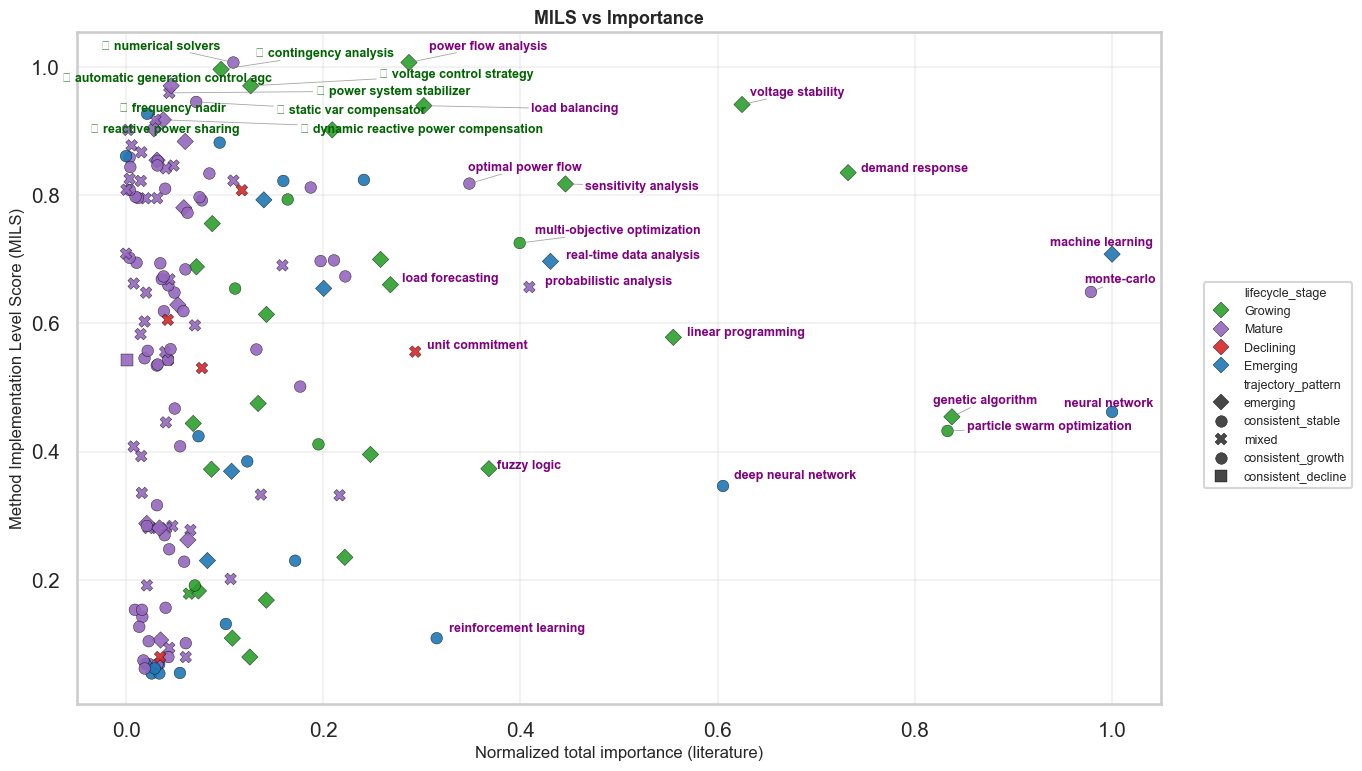

In [ ]:


# Just the GGT plot with low corner labels
scatter_mis_vs_ggt_and_importance(
    merged,
    plot_mode='importance',
    # Top-right: Winners (high MIS + growing)
    label_high_growth=True,
    ggt_threshold=0.12,
    max_growth_labels=15,
    # Top (any x): High MIS
    label_high_mis=True,
    mis_threshold=0.85,
    max_mis_labels=12,
    # Top-left: Legacy (high MIS + declining)
    label_high_mis_declining=True,
    high_mis_low_ggt_threshold=-0.02,  # Declining at least 5%
    max_high_mis_declining_labels=10,
    # Bottom-left: Failing (low MIS + declining)
    label_low_corner=True,
    low_mis_threshold=0.35,
    low_ggt_threshold=-0.08,
    max_low_labels=8,
    #importance plot labels
    label_high_importance=True,
    imp_threshold=100,
    #imp_quantile=0.90,
    max_importance_labels=20,
    save_prefix=f'{SAVE_DIR}/all_corners_labeled'
)




💾 Saved: Comparison_outputs\all_corners_labeled_MILS_recent_ggt.pdf


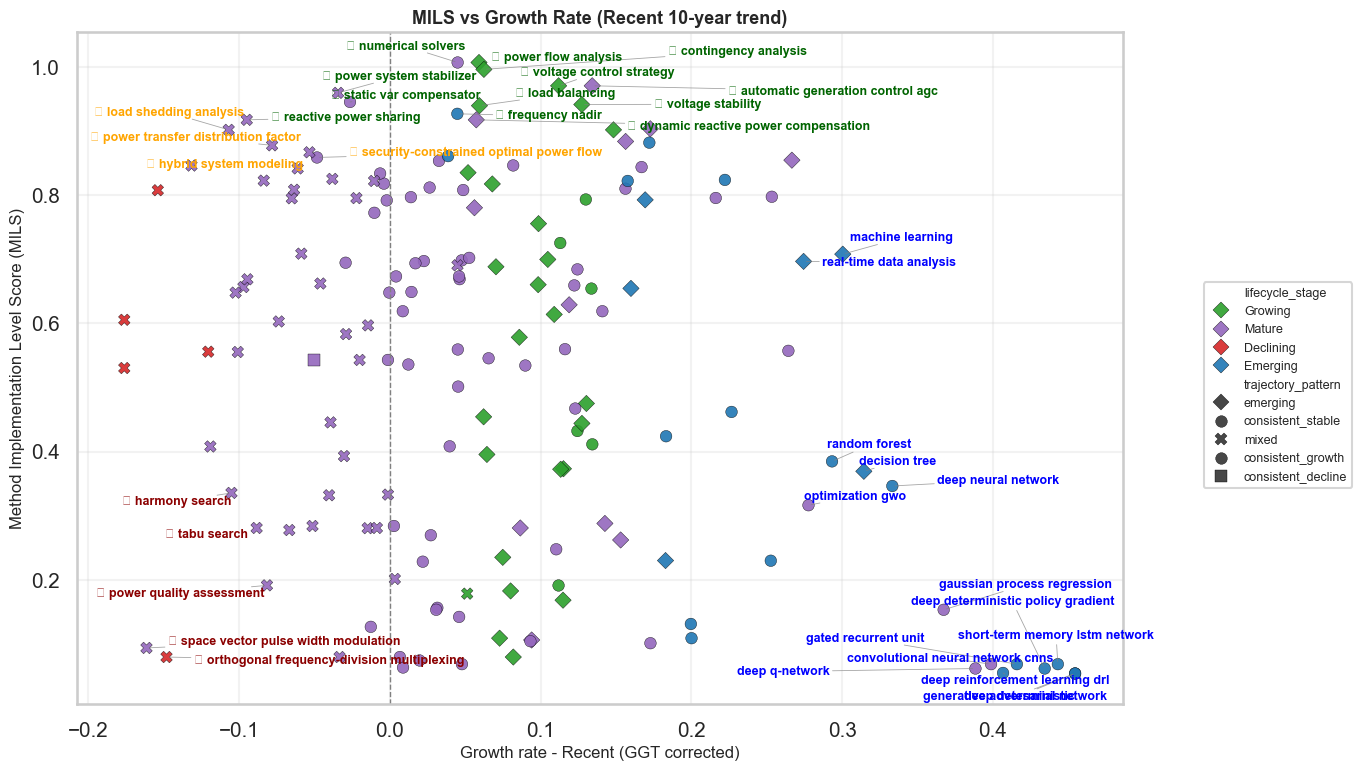


📊 CORNER ANALYSIS SUMMARY:

📦 TOP-LEFT (Legacy Methods - High MILS, Declining):
  Criteria: MILS ≥ 0.850, GGT ≤ -0.020
  Found: 7 methods (well-implemented but losing traction)

⚠️  BOTTOM-LEFT (Failing Methods - Low MILS, Declining):
  Criteria: MILS ≤ 0.350, GGT ≤ -0.080
  Found: 5 methods (poorly implemented AND declining)


In [ ]:
scatter_mis_vs_ggt_and_importance(
    merged,
    plot_mode='ggt',#'both', 'ggt', or 'importance'
    # Top-right: Winners (high MIS + growing)
    label_high_growth=True,
    ggt_threshold=0.12,
    max_growth_labels=15,
    # Top (any x): High MIS
    label_high_mis=True,
    mis_threshold=0.85,
    max_mis_labels=12,
    # Top-left: Legacy (high MIS + declining)
    label_high_mis_declining=True,
    high_mis_low_ggt_threshold=-0.02,  # Declining at least 5%
    max_high_mis_declining_labels=10,
    # Bottom-left: Failing (low MIS + declining)
    label_low_corner=True,
    low_mis_threshold=0.35,
    low_ggt_threshold=-0.08,
    max_low_labels=8,
    #importance plot labels
    label_high_importance=True,
    imp_threshold=100,
    #imp_quantile=0.90,
    max_importance_labels=20,
    save_prefix=f'{SAVE_DIR}/all_corners_labeled'
)



### Updated version of scatter plot

In [33]:
# ============================================
# Scatter_mis_vs_ggt_and_importance FOR NEW DATA
# ============================================
def scatter_comparison_plots(
    df_comparison,
    save_prefix=None,
    color_by="lifecycle_stage",
    figsize=None,
    s=70,
    alpha=0.9,
    linewidth=0.3,
    label_high_growth=True,
    ggt_quantile=0.90,
    max_growth_labels=20,
    label_high_mis=True,
    max_mis_labels=15,
    label_high_importance=True,
    imp_quantile=0.90,
    max_importance_labels=15,
    label_high_survey=True,  # NEW: Label high survey scores
    survey_quantile=0.90,    # NEW
    max_survey_labels=15,    # NEW
    plot_mode='all',  # NEW: 'all', 'mils_ggt', 'mils_lit', 'mils_survey'
    trend_type='recent',
    show_trajectory=True
):
    """
    Enhanced scatter plots for comprehensive comparison.
    
    Supports three dimensions:
    - MILS (Software implementation)
    - GGT (Literature growth)
    - Literature importance
    - Survey scores (NEW!)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    df = df_comparison.copy()
    
    # Determine which column names to use
    mis_col = 'Software_Norm' if 'Software_Norm' in df.columns else 'Software_MIS'
    lit_col = 'Literature_Norm' if 'Literature_Norm' in df.columns else 'Literature_Score'
    survey_col = 'Survey_Norm' if 'Survey_Norm' in df.columns else 'Survey_Score'
    
    # Determine GGT column
    if trend_type == 'recent':
        ggt_col = 'ggt_corrected_growth_recent' if 'ggt_corrected_growth_recent' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_label = "Growth rate - Recent (GGT corrected)"
    elif trend_type == 'full':
        ggt_col = 'ggt_corrected_growth_full' if 'ggt_corrected_growth_full' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_label = "Growth rate - Full history (GGT corrected)"
    else:
        ggt_col = 'ggt_corrected_growth_recent'
        ggt_label = "Growth rate - Recent (GGT corrected)"
    
    # Setup colors and markers
    hue = color_by if color_by in df.columns else None
    pal = {'Emerging':'#1f77b4','Growing':'#2ca02c','Mature':'#9467bd','Declining':'#d62728'} \
          if hue == 'lifecycle_stage' else None
    
    style = None
    markers = None
    if show_trajectory and 'trajectory_pattern' in df.columns:
        style = 'trajectory_pattern'
        markers = {
            'resurgent': '^', 'die_hard': 'v', 'consistent_growth': 'o',
            'consistent_decline': 's', 'emerging': 'D',
            'consistent_stable': 'o', 'mixed': 'X'
        }
    
    # Determine figure layout
    if plot_mode == 'all':
        figsize = figsize or (18, 6)
        fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=True)
        axes = list(axes)  # Convert to list
    elif plot_mode == 'comparison':
        figsize = figsize or (16, 7)
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
        axes = list(axes)  # Convert to list
    else:
        figsize = figsize or (10, 8)
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        axes = [ax]  # Already a list
    
    label_col = 'Method'
    
    # ========== Panel 1: MILS vs GGT ==========
    if plot_mode in ['all', 'mils_ggt', 'comparison']:
        ax_idx = 0
        ax = axes[ax_idx]
        
        if ggt_col in df.columns:
            sns.scatterplot(
                data=df, x=ggt_col, y=mis_col, hue=hue, style=style, markers=markers,
                palette=pal, s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
            )
            ax.axvline(0, color="gray", ls="--", lw=1)
            ax.set_xlabel(ggt_label, fontsize=11)
            ax.set_ylabel("Software Implementation (MILS)", fontsize=11)
            ax.set_title("MILS vs Literature Growth", fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.25)
            
            # Label high growth methods
            if label_high_growth and ggt_col in df.columns:
                thr = df[ggt_col].quantile(ggt_quantile)
                hi = df[df[ggt_col] >= thr].nlargest(max_growth_labels, ggt_col)
                for _, r in hi.iterrows():
                    ax.text(r[ggt_col], r[mis_col], f"  {r[label_col]}",
                           fontsize=8, ha='left', va='center', color='blue', weight='bold')
    
    # ========== Panel 2: MILS vs Literature Importance ==========
    if plot_mode in ['all', 'mils_lit', 'comparison']:
        ax_idx = 1 if plot_mode == 'all' else (1 if plot_mode == 'comparison' else 0)
        ax = axes[ax_idx]
        
        if lit_col in df.columns:
            sns.scatterplot(
                data=df, x=lit_col, y=mis_col, hue=hue, style=style, markers=markers,
                palette=pal, s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
            )
            ax.set_xlabel("Literature Importance", fontsize=11)
            ax.set_ylabel("Software Implementation (MILS)", fontsize=11)
            ax.set_title("MILS vs Literature Importance", fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.25)
            
            # Label high importance methods
            if label_high_importance and lit_col in df.columns:
                thr = df[lit_col].quantile(imp_quantile)
                hi = df[df[lit_col] >= thr].nlargest(max_importance_labels, lit_col)
                for _, r in hi.iterrows():
                    ax.text(r[lit_col], r[mis_col], f"  {r[label_col]}",
                           fontsize=8, ha='left', va='center', color='purple', weight='bold')
    
    # ========== Panel 3: MILS vs Survey (User Adoption) ========== (NEW!)
    if plot_mode in ['all', 'mils_survey']:
        ax_idx = 2 if plot_mode == 'all' else 0
        ax = axes[ax_idx]
        
        if survey_col in df.columns and df[survey_col].notna().sum() > 0:
            sns.scatterplot(
                data=df, x=survey_col, y=mis_col, hue=hue, style=style, markers=markers,
                palette=pal, s=s, alpha=alpha, edgecolor="k", linewidth=linewidth, ax=ax
            )
            ax.set_xlabel("Survey Score (User Adoption)", fontsize=11)
            ax.set_ylabel("Software Implementation (MILS)", fontsize=11)
            ax.set_title("MILS vs User Adoption", fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.25)
            
            # Label high survey methods
            if label_high_survey and survey_col in df.columns:
                thr = df[survey_col].quantile(survey_quantile)
                hi = df[df[survey_col] >= thr].nlargest(max_survey_labels, survey_col)
                for _, r in hi.iterrows():
                    ax.text(r[survey_col], r[mis_col], f"  {r[label_col]}",
                           fontsize=8, ha='left', va='center', color='darkgreen', weight='bold')
        else:
            ax.text(0.5, 0.5, "No survey data available",
                   transform=ax.transAxes, ha='center', fontsize=12)
            ax.set_axis_off()
    
    # Legend
    if hue or style:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.15, 0.5), fontsize=9)
            for ax in (axes):
                leg = ax.get_legend()
                if leg: leg.remove()
    
    plt.tight_layout()
    
    if save_prefix:
        from pathlib import Path
        Path(save_prefix).parent.mkdir(parents=True, exist_ok=True)
        out = Path(save_prefix).with_name(Path(save_prefix).stem + f"_comparison_{plot_mode}.pdf")
        fig.savefig(out, bbox_inches="tight")
        print(f"💾 Saved: {out}")
    
    plt.show()
    
    return df

In [34]:
# ============================================
# ENHANCED plot_survey_comparisons() WITH ALL FEATURES
# ============================================

def plot_survey_comparisons(
    df_comparison,
    compare_with=['importance', 'MILS', 'growth'],  # NEW: Choose dimensions!
    save_prefix=None,
    trend_type='recent',
    color_by='lifecycle_stage',
    filter_by=None,
    filter_values=None,
    label_methods=True,
    label_quantile=0.90,
    max_labels=15,
    figsize=None,  # Auto-calculated based on number of panels
    s=100,
    alpha=0.7
):
    """
    Flexible survey comparison - choose which dimensions to compare.
    
    Parameters:
    -----------
    df_comparison : DataFrame
        Output from compare_all_sources()
    compare_with : list of str
        Dimensions to compare survey against. Options:
        - 'importance': Literature importance
        - 'MILS': Software implementation
        - 'growth': Literature growth rate (GGT)
        Can be any combination, e.g. ['MILS', 'growth'] or ['importance'] only
    trend_type : str
        'recent' or 'full' - which GGT growth rate to use (if 'growth' in compare_with)
    color_by : str
        Column to color by: 'lifecycle_stage', 'category', 'classification', etc.
    filter_by : str
        Column to filter by
    filter_values : list
        Values to keep
    label_methods : bool
        Whether to label high-scoring methods
    
    Returns:
    --------
    fig, axes
    
    Examples:
    ---------
    # All three dimensions (default)
    plot_survey_comparisons(df_comparison)
    
    # Only MILS vs Survey
    plot_survey_comparisons(df_comparison, compare_with=['MILS'])
    
    # Growth and Importance (skip MILS)
    plot_survey_comparisons(df_comparison, compare_with=['importance', 'growth'])
    
    # Just growth rate
    plot_survey_comparisons(
        df_comparison, 
        compare_with=['growth'],
        trend_type='full',
        figsize=(10, 8)
    )
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Validate compare_with
    valid_dimensions = ['importance', 'MILS', 'growth']
    compare_with = [d for d in compare_with if d in valid_dimensions]
    
    if not compare_with:
        raise ValueError(f"compare_with must contain at least one of: {valid_dimensions}")
    
    n_panels = len(compare_with)
    
    # Auto-calculate figure size if not provided
    if figsize is None:
        if n_panels == 1:
            figsize = (10, 8)
        elif n_panels == 2:
            figsize = (16, 7)
        else:  # 3 panels
            figsize = (18, 6)
    
    # Filter data: only methods with survey scores
    df = df_comparison[df_comparison['Survey_Score'] > 0].copy()
    
    # Apply additional filtering if requested
    if filter_by and filter_values:
        if filter_by in df.columns:
            df = df[df[filter_by].isin(filter_values)].copy()
            print(f"Filtered by {filter_by}: {len(df)} methods remaining")
        else:
            print(f"⚠️  Warning: Column '{filter_by}' not found")
    
    # Determine GGT column based on trend_type
    if trend_type == 'full':
        ggt_col = 'ggt_corrected_growth_full' if 'ggt_corrected_growth_full' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_label = "Literature Growth Rate (GGT Full)"
    else:  # recent
        ggt_col = 'ggt_corrected_growth_recent' if 'ggt_corrected_growth_recent' in df.columns \
                  else 'ggt_corrected_growth'
        ggt_label = "Literature Growth Rate (GGT Recent)"
    
    # Setup colors
    hue = None
    palette = None
    
    if color_by and color_by in df.columns:
        hue = color_by
        
        if color_by == 'lifecycle_stage':
            palette = {
                'Emerging': '#1f77b4',
                'Growing': '#2ca02c',
                'Mature': '#9467bd',
                'Declining': '#d62728'
            }
    
    # Create figure with dynamic number of panels
    fig, axes = plt.subplots(1, n_panels, figsize=figsize, squeeze=False)
    axes = axes.flatten()  # Make it always iterable
    
    # Panel counter
    panel_idx = 0
    
    # Define panel configurations
    panel_configs = {
        'importance': {
            'x_col': 'Literature_Norm',
            'x_label': 'Literature Importance (Normalized)',
            'title': 'User Adoption vs Literature Importance',
            'label_color': 'darkblue',
            'score_name': 'combined_lit_survey',
            'calc': lambda: df['Literature_Norm'] + df['Survey_Norm']
        },
        'MILS': {
            'x_col': 'Software_Norm',
            'x_label': 'Software Implementation (MILS Normalized)',
            'title': 'User Adoption vs Software Implementation',
            'label_color': 'darkgreen',
            'score_name': 'combined_soft_survey',
            'calc': lambda: df['Software_Norm'] + df['Survey_Norm']
        },
        'growth': {
            'x_col': ggt_col,
            'x_label': ggt_label,
            'title': 'User Adoption vs Literature Growth',
            'label_color': 'purple',
            'score_name': 'growth_survey_score',
            'calc': lambda: df[ggt_col] + df['Survey_Norm'] if ggt_col in df.columns else None
        }
    }
    
    # Create each requested panel
    for dimension in compare_with:
        config = panel_configs[dimension]
        ax = axes[panel_idx]
        
        # Check if data is available
        if config['x_col'] not in df.columns:
            ax.text(0.5, 0.5, f"{dimension.upper()} data not available",
                   transform=ax.transAxes, ha='center', fontsize=12)
            ax.set_axis_off()
            panel_idx += 1
            continue
        
        # Create scatter plot
        sns.scatterplot(
            data=df, x=config['x_col'], y='Survey_Norm',
            hue=hue, palette=palette,
            s=s, alpha=alpha, edgecolor='k', linewidth=0.5, ax=ax
        )
        
        ax.set_xlabel(config['x_label'], fontsize=11)
        ax.set_ylabel("User Adoption (Survey Score)", fontsize=11)
        ax.set_title(config['title'], fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Add reference lines
        if dimension == 'growth':
            ax.axvline(0, color='gray', ls='--', lw=1, alpha=0.5)
        else:
            ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1, label='Perfect match')
        
        # Label high-scoring methods
        if label_methods:
            score_calc = config['calc']()
            if score_calc is not None:
                df[config['score_name']] = score_calc
                thr = df[config['score_name']].quantile(label_quantile)
                top = df[df[config['score_name']] >= thr].nlargest(max_labels, config['score_name'])
                
                for _, row in top.iterrows():
                    ax.text(row[config['x_col']], row['Survey_Norm'], 
                           f"  {row['Method']}", fontsize=8, ha='left', va='center',
                           color=config['label_color'], weight='bold', alpha=0.8)
        
        panel_idx += 1
    
    # Remove individual legends
    for ax in axes:
        leg = ax.get_legend()
        if leg: 
            leg.remove()
    
    # Add common legend if colored
    if hue:
        handles, labels = axes[0].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, 
                      loc='center right', 
                      bbox_to_anchor=(1.12, 0.5), 
                      fontsize=9,
                      title=color_by.replace('_', ' ').title())
    
    plt.tight_layout()
    
    # Save if requested
    if save_prefix:
        from pathlib import Path
        Path(save_prefix).parent.mkdir(parents=True, exist_ok=True)
        
        dims_str = "_".join(compare_with)
        suffix = f"_{dims_str}_{trend_type}" if 'growth' in compare_with else f"_{dims_str}"
        if filter_by:
            suffix += f"_{filter_by}"
        
        out = Path(save_prefix).with_name(
            Path(save_prefix).stem + f"_survey{suffix}.pdf"
        )
        fig.savefig(out, bbox_inches="tight", dpi=300)
        print(f"💾 Saved: {out}")
    
    plt.show()
    
    # Print correlation statistics
    print(f"\\n📊 SURVEY CORRELATION ANALYSIS:")
    print("="*60)
    
    if 'importance' in compare_with:
        print(f"Survey vs Literature:  r = {df['Survey_Norm'].corr(df['Literature_Norm']):.3f}")
    if 'MILS' in compare_with:
        print(f"Survey vs MILS:        r = {df['Survey_Norm'].corr(df['Software_Norm']):.3f}")
    if 'growth' in compare_with and ggt_col in df.columns:
        print(f"Survey vs GGT ({trend_type}): r = {df['Survey_Norm'].corr(df[ggt_col]):.3f}")
    
    print(f"\\nMethods analyzed: {len(df)}")
    print(f"Dimensions compared: {', '.join(compare_with)}")
    if filter_by:
        print(f"Filtered by {filter_by}: {filter_values}")
    print("="*60)
    
    return fig, axes

### Make the plots

💾 Saved: output\method_comparison_comparison_all.pdf


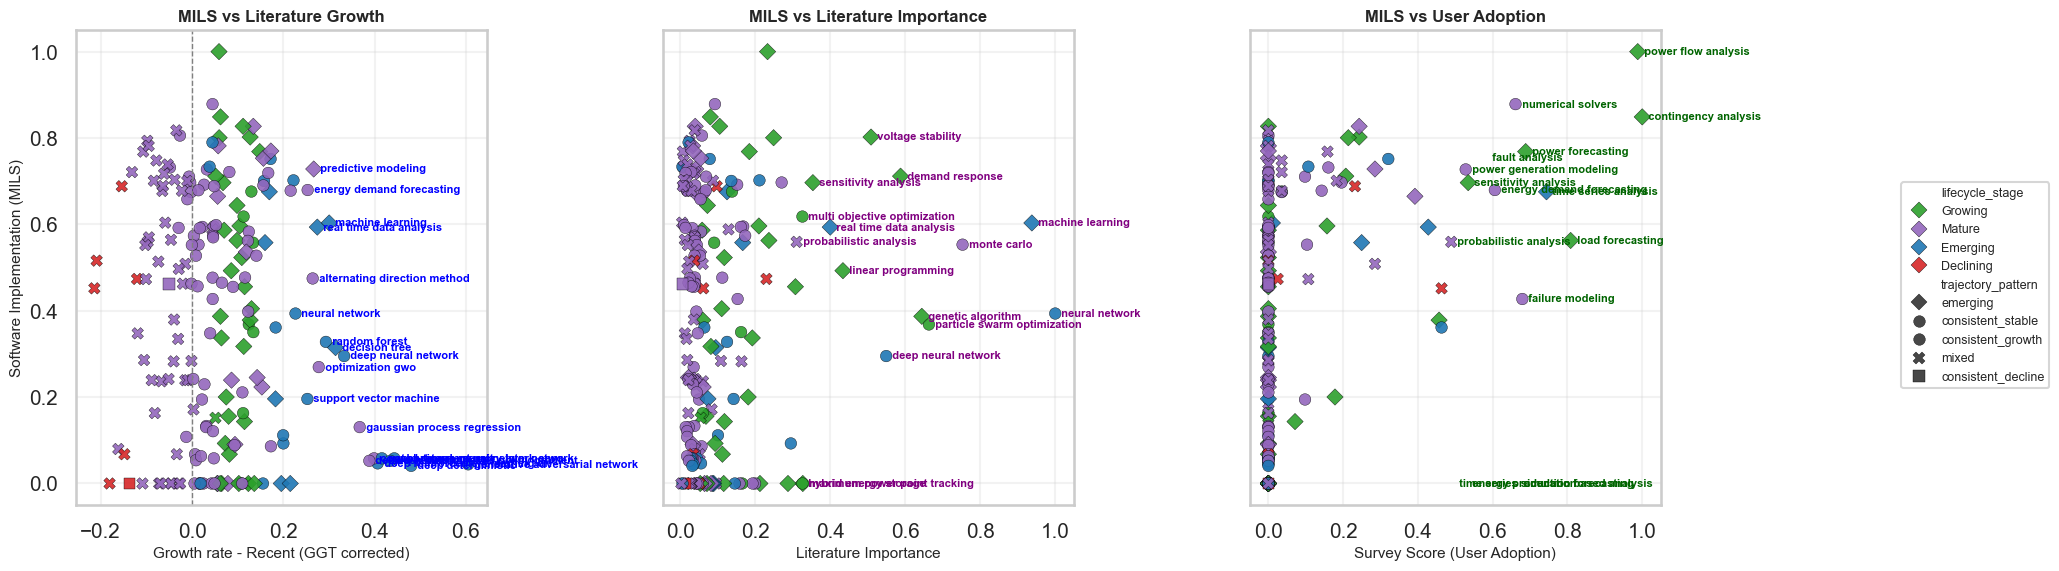

,Method,Literature_Score,Software_MIS,Survey_Score,Literature_Norm,Software_Norm,Survey_Norm,Average_Norm,Lit_vs_Soft_Gap,Lit_vs_Survey_Gap,Soft_vs_Survey_Gap,lifecycle_stage,trajectory_pattern,ggt_corrected_growth_recent,ggt_corrected_growth_full,total_importance,peak_ratio,years_active,category
152,power flow analysis,158.968378,1.1734,0.840152,0.232812,1.000000,0.987973,0.740262,-0.767188,-0.755161,0.012027,Growing,emerging,0.059087,0.023532,145.219546,5.047044,31.0,"Power, load and capacity modeling"
17,contingency analysis,54.688059,0.9961,0.850379,0.080092,0.848901,1.000000,0.642997,-0.768809,-0.919908,-0.151099,Growing,emerging,0.062330,-0.001418,51.195589,3.107214,22.0,Reliability and contingency analysis
153,power forecasting,125.748618,0.9018,0.585227,0.184161,0.768536,0.688196,0.546964,-0.584374,-0.504035,0.080340,Growing,emerging,0.148288,0.000635,106.830843,6.094032,25.0,"Power, load and capacity modeling"
136,numerical solvers,63.112696,1.0308,0.562121,0.092430,0.878473,0.661024,0.543976,-0.786043,-0.568595,0.217448,Mature,consistent_stable,0.044929,-0.020221,57.377473,2.972229,23.0,Other
100,load forecasting,161.406223,0.6603,0.687500,0.236383,0.562724,0.808463,0.535857,-0.326341,-0.572081,-0.245740,Growing,emerging,0.098326,0.016390,135.931349,5.703249,26.0,"Power, load and capacity modeling"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,value of lost load,7.317591,0.0000,0.000000,0.010717,0.000000,0.000000,0.003572,0.010717,0.010717,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
182,security constrained economic dispatch,4.147819,0.0000,0.000000,0.006075,0.000000,0.000000,0.002025,0.006075,0.006075,0.000000,Emerging,consistent_stable,0.018857,0.018857,4.147381,1.691255,5.0,Other
37,doubly fed induction generation,2.013306,0.0000,0.000000,0.002949,0.000000,0.000000,0.000983,0.002949,0.002949,0.000000,Mature,mixed,-0.108564,-0.108564,2.013300,2.619127,7.0,Other
58,event driven simulation,1.160001,0.0000,0.000000,0.001699,0.000000,0.000000,0.000566,0.001699,0.001699,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other


In [43]:
# All three comparisons (MILS vs GGT, Literature, Survey)
scatter_comparison_plots(
    df_comparison,
    plot_mode='all',
    save_prefix='output/method_comparison'
)



💾 Saved: output\mils_vs_survey_comparison_mils_survey.pdf


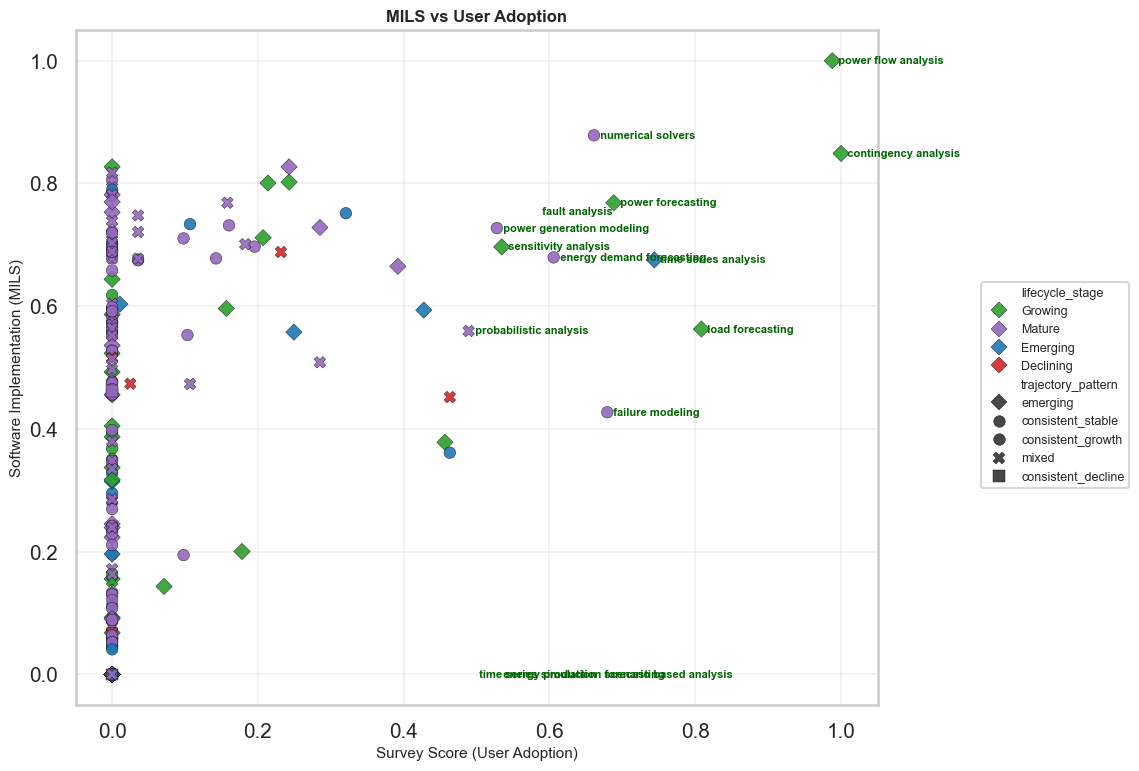

,Method,Literature_Score,Software_MIS,Survey_Score,Literature_Norm,Software_Norm,Survey_Norm,Average_Norm,Lit_vs_Soft_Gap,Lit_vs_Survey_Gap,Soft_vs_Survey_Gap,lifecycle_stage,trajectory_pattern,ggt_corrected_growth_recent,ggt_corrected_growth_full,total_importance,peak_ratio,years_active,category
152,power flow analysis,158.968378,1.1734,0.840152,0.232812,1.000000,0.987973,0.740262,-0.767188,-0.755161,0.012027,Growing,emerging,0.059087,0.023532,145.219546,5.047044,31.0,"Power, load and capacity modeling"
17,contingency analysis,54.688059,0.9961,0.850379,0.080092,0.848901,1.000000,0.642997,-0.768809,-0.919908,-0.151099,Growing,emerging,0.062330,-0.001418,51.195589,3.107214,22.0,Reliability and contingency analysis
153,power forecasting,125.748618,0.9018,0.585227,0.184161,0.768536,0.688196,0.546964,-0.584374,-0.504035,0.080340,Growing,emerging,0.148288,0.000635,106.830843,6.094032,25.0,"Power, load and capacity modeling"
136,numerical solvers,63.112696,1.0308,0.562121,0.092430,0.878473,0.661024,0.543976,-0.786043,-0.568595,0.217448,Mature,consistent_stable,0.044929,-0.020221,57.377473,2.972229,23.0,Other
100,load forecasting,161.406223,0.6603,0.687500,0.236383,0.562724,0.808463,0.535857,-0.326341,-0.572081,-0.245740,Growing,emerging,0.098326,0.016390,135.931349,5.703249,26.0,"Power, load and capacity modeling"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,value of lost load,7.317591,0.0000,0.000000,0.010717,0.000000,0.000000,0.003572,0.010717,0.010717,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other
182,security constrained economic dispatch,4.147819,0.0000,0.000000,0.006075,0.000000,0.000000,0.002025,0.006075,0.006075,0.000000,Emerging,consistent_stable,0.018857,0.018857,4.147381,1.691255,5.0,Other
37,doubly fed induction generation,2.013306,0.0000,0.000000,0.002949,0.000000,0.000000,0.000983,0.002949,0.002949,0.000000,Mature,mixed,-0.108564,-0.108564,2.013300,2.619127,7.0,Other
58,event driven simulation,1.160001,0.0000,0.000000,0.001699,0.000000,0.000000,0.000566,0.001699,0.001699,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Other


In [44]:
# Just MILS vs Survey
scatter_comparison_plots(
    df_comparison,
    plot_mode='mils_survey',
    label_high_survey=True,
    label_high_mis=True,
    save_prefix='output/mils_vs_survey'
)

💾 Saved: Comparison_outputs\survey_analysis_survey_importance.pdf


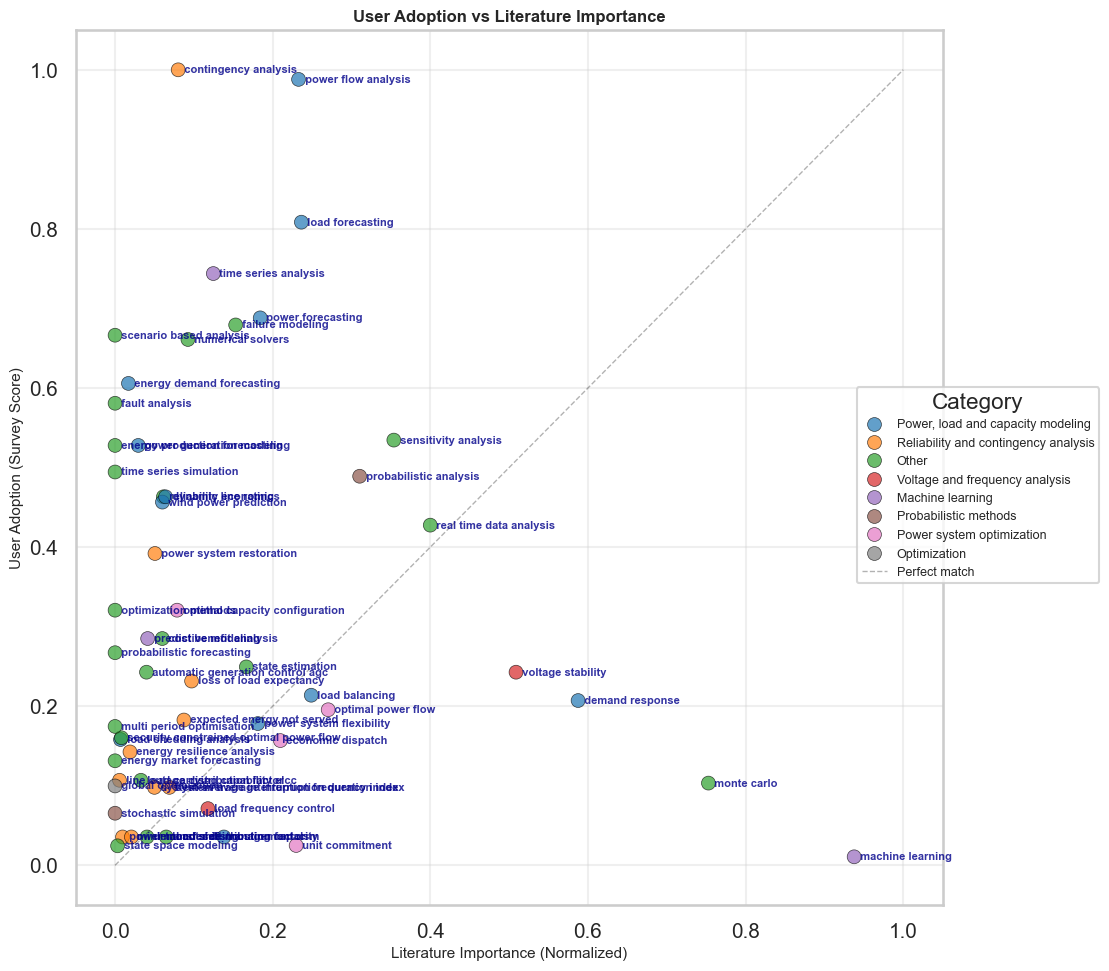

\n📊 SURVEY CORRELATION ANALYSIS:
Survey vs Literature:  r = -0.051
\nMethods analyzed: 56
Dimensions compared: importance


(<Figure size 1000x1000 with 1 Axes>,
 array([<Axes: title={'center': 'User Adoption vs Literature Importance'}, xlabel='Literature Importance (Normalized)', ylabel='User Adoption (Survey Score)'>],
       dtype=object))

In [57]:
# Usage
# trend_type : str
#        compare_with : list of str
#        
#    filter_by : str
#        
#    filter_values : list
#        Values to keep (e.g., ['Growing', 'Mature'])
#    label_methods : bool
##        Whether to label high-scoring methods
#    label_quantile : float
#        
#    max_labels : int
#        


#    default values                # options
#    save_prefix=None,
#    compare_with=['importance', 'MILS', 'growth'],  # Dimensions to compare survey against
#    trend_type='recent',          #'recent' or 'full' - which GGT growth rate to use
#    color_by='lifecycle_stage',   # Column to color by: 'lifecycle_stage', 'category', 'classification','trajectory_pattern', or None
#    filter_by=None,               # NEW: Filter data
#    filter_values=None,           # Values to keep (e.g., ['Growing', 'Mature'])
#    label_methods=True,           # Label points
#    label_quantile=0.90,          # Quantile threshold for labeling (0.90 = top 10%)
#    max_labels=15,                # Maximum labels per panel
#    figsize=(18, 6),
#    s=100,
#    alpha=0.7
    
plot_survey_comparisons(df_comparison, figsize=(10,10),
                        compare_with=['importance'], #['importance', 'MILS', 'growth']
                        save_prefix=f'{SAVE_DIR}/survey_analysis',
                        label_methods=True,
                        label_quantile=0.,
                        max_labels=100,
                        trend_type='recent',
                        color_by='category'
                        )
